In [1]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os

import seaborn as sns
from matplotlib import pyplot
from matplotlib_venn import venn2, venn3
import pybedtools
import numpy as np
from IPython.core.display import HTML
import pandas as pd

from gscripts import GO
from gscripts.rnaseq import splicing_map
from gscripts.general import dataviz
from gscripts.general import region_helpers

img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/splicing_maps"
heatmap_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/heatmaps"

In [2]:
previous_cryptic_events = """EPB41L4A
CEP72
INSR
FAM114A2
PFKP
ST5
RNFT2
RNFT2
ALX1
AGRN
AGRN
ATG4B
AGRN
AGRN
ST5
SETD5
KDELC2
MUC16
PKN1
IRF9
UPF2
GPSM2
XPO4
RASA4
RASA4B
PARP6
KRT7
TRAPPC12
RANBP1
HERC6
BLZF1
ZFP91
HDGFRP2
MAP3K8
SSFA2
CENPK
ITPR3
KYNU
IRF9
COL4A6
KYNU""".split("\n")

In [3]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [4]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [5]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

def leaves(t, t2=None):
    """ Returns the leaves of a ClusterNode """
    try:
        return t.pre_order()
    except AttributeError:
        if t2 is not None:
            return t2.pre_order()
        else:
            return []

# For an element x, returns the set that x isn't in
other = lambda x, V, W: W if x in V else V
M = {}

def optimal_scores(v, D, fast=True):
    """ Implementation of Ziv-Bar-Joseph et al.'s leaf order algorithm
    v is a ClusterNode
    D is a distance matrix """
    def score_func(left, right, u, m, w, k):
        return Mfunc(left, u, m) + Mfunc(right, w, k) + D[m, k]
    
    def Mfunc(v, a, b):
        if a == b:
            M[v, a, b] = 0
        return M[v, a, b]
    
    if v.is_leaf():
        n = v.get_id()
        M[v, n, n] = 0
        return 0
    else:
        L = leaves(v.left)
        R = leaves(v.right)
        LL = leaves(v.left.left, v.left)
        LR = leaves(v.left.right, v.left)
        RL = leaves(v.right.left, v.right)
        RR = leaves(v.right.right, v.right)
        for l in L:
            for r in R:
                M[v.left, l, r] = slow_optimal_scores(v.left, D)
                M[v.right, l, r] = slow_optimal_scores(v.right, D)
                for u in L:
                    for w in R:
                        if fast:
                            m_order = sorted(other(u, LL, LR), key=lambda m: Mfunc(v.left, u, m))
                            k_order = sorted(other(w, RL, RR), key=lambda k: Mfunc(v.right, w, k))
                            C = min([D[m, k] for m in other(u, LL, LR) for k in other(w, RL, RR)])
                            Cmin = 1e10
                            for m in m_order:
                                if M[v.left, u, m] + M[v.right, w, k_order[0]] + C >= Cmin:
                                    break
                                for k in k_order:
                                    if M[v.left, u, m] + M[v.right, w, k] + C >= Cmin:
                                        break
                                    C = score_func(v.left, v.right, u, m, w, k)
                                    if C < Cmin:
                                        Cmin = C
                            M[v, u, w] = M[v, w, u] = Cmin
                        else:
                            M[v, u, w] = M[v, w, u] = \
                                min([score_func(v.left, v.right, u, m, w, k) \
                                    for m in other(u, LL, LR) \
                                    for k in other(w, RL, RR)])
                return M[v, l, r]

slow_optimal_scores = lambda v, D: optimal_scores(v, D, fast=False)
fast_optimal_scores = lambda v, D: optimal_scores(v, D, fast=True)

def order_tree(v, D, fM=None, scores=slow_optimal_scores):
    """ Returns an optimally ordered tree """
    # Generate scores the first pass
    if fM is None:
        fM = 1
        scores(v, D)
    
    L = leaves(v.left)
    R = leaves(v.right)
    if len(L) and len(R):
        u, w = min([(u, w) for u in L for w in R], key=lambda (u,w): M[v, u, w])
        if w in leaves(v.right.left):
            v.right.right, v.right.left = v.right.left, v.right.right
        if u in leaves(v.left.right):
            v.left.left, v.left.right = v.left.right, v.left.left
        v.left = order_tree(v.left, D, fM)
        v.right = order_tree(v.right, D, fM)
    return v

@property
def reordered_ind(self):
    M = {}
    tree = hierarchy.to_tree(self.linkage)
    dists = distance.squareform(distance.pdist(self.array, metric=self.metric))
    return leaves(order_tree(tree, dists))

old_ind = sns.matrix._DendrogramPlotter.reordered_ind
sns.matrix._DendrogramPlotter.reordered_ind = reordered_ind

#Assemble Useful Tables

In [6]:
master_processing_table = pd.read_table("/home/elvannostrand/data/ENCODE/project_stuff/ENCODE_MASTER_ID_LIST_20160301_AllDatasets.txt", 
                                        sep="\t",
                                        skiprows=1,
                                        names=["UID", "RBP_gID", "CellLine", "RBP_ENSG", "Antibody", "Lot", "CLIP_ENCODEAccID", "CLIP_Rep1ENC", "CLIP_Rep2ENC", "CLIP_InputENC", "RNASEQ_ENCODEAccID",  "Duplicate_RNASEQ_ENCODEAccID", "RNASEQ_ControlENC", "RNASEQ_KDRep1Bam", "RNASEQ_KDRep2Bam", "RNASEQ_ControlRep1Bam", "RNASEQ_ControlRep2Bam", "bar"]
)

#Load SE Events

In [7]:
all_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/ipython_data/merged_cryptic_events.csv", 
            index_col=[0,1,2,3,4,5])

all_events.rename(columns={"rbp.1": "rbp", "cell_type.1": "cell_type", "both.1": "both"}, inplace=True)
id_to_name = dict(izip(all_events.index.get_level_values(level="condition"), all_events.index.get_level_values(level="both")))


/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
def get_significant_events(events):
    sig_events = events[events.FDR < .05]
    sig_events = pd.concat({"excluded": sig_events[sig_events.IncLevelDifference < 0],
                            "included": sig_events[sig_events.IncLevelDifference > 0],}, 
                           names=["direction", "event_type", "condition", "both", "rbp", "cell_type", "event_id"])
    sig_events = sig_events.swaplevel(0,1)
    return sig_events

all_sig_events = get_significant_events(all_events)
background_events = all_events[all_events.FDR > .05]

all_sig_stress_events = all_sig_events[all_sig_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]
background_stress_events = background_events[background_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]

#Count number of events

In [18]:
num_events = all_sig_stress_events.groupby(level=["event_type", "direction", "condition"]).count().GeneID.unstack().T

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [19]:
num_events_encode = all_sig_events.groupby(level=["event_type", "direction", "condition"]).count().GeneID.unstack().T 

In [20]:
se_sig_stress_events = all_sig_stress_events.xs("SE")

In [21]:
combined_events = num_events.T.groupby(level="event_type").sum().T
combined_events_encode = num_events_encode.T.groupby(level="event_type").sum().T

In [22]:
sort_order = """hs1_HepG2_vs_WT_HepG2
hs1_K562_vs_WT_K562
ars1_HepG2_vs_WT_HepG2
ars1_K562_vs_WT_K562
PQ1_HepG2_vs_WT_HepG2
PQ1_K562_vs_WT_K562
CA_HepG2_vs_WT_HepG2
CA_K562_vs_WT_K562
PQCA1_HepG2_vs_WT_HepG2
PQCA1_K562_vs_WT_K562""".split("\n")

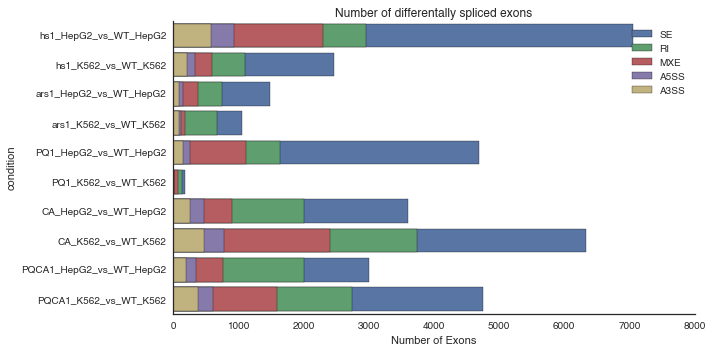

In [23]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events.ix[sort_order]

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        sns.barplot(x=cumsum_num_events[splice_type], y=cumsum_num_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Number of differentally spliced exons")
        ax.set_xlabel("Number of Exons")
        sns.despine(ax=ax)

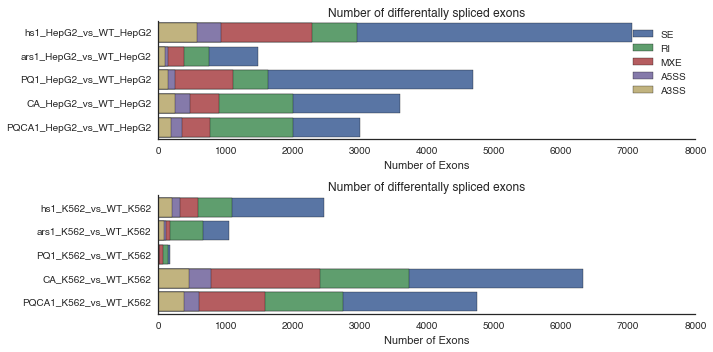

In [24]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events.ix[sort_order]

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split.svg"), figsize=(10, 5)) as fig:
    hepg2_ax = fig.add_subplot(2,1,1)
    k562_ax = fig.add_subplot(2,1,2)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HepG2" in x)]
        sns.barplot(x=hepg2_cumsum[splice_type], y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        hepg2_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_yticklabels()]
        hepg2_ax.set_ylabel("")
        
        k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HepG2" in x)]

        
        sns.barplot(x=k562_cumsum[splice_type], y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        k562_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in k562_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in k562_ax.get_yticklabels()]
        k562_ax.set_ylabel("")


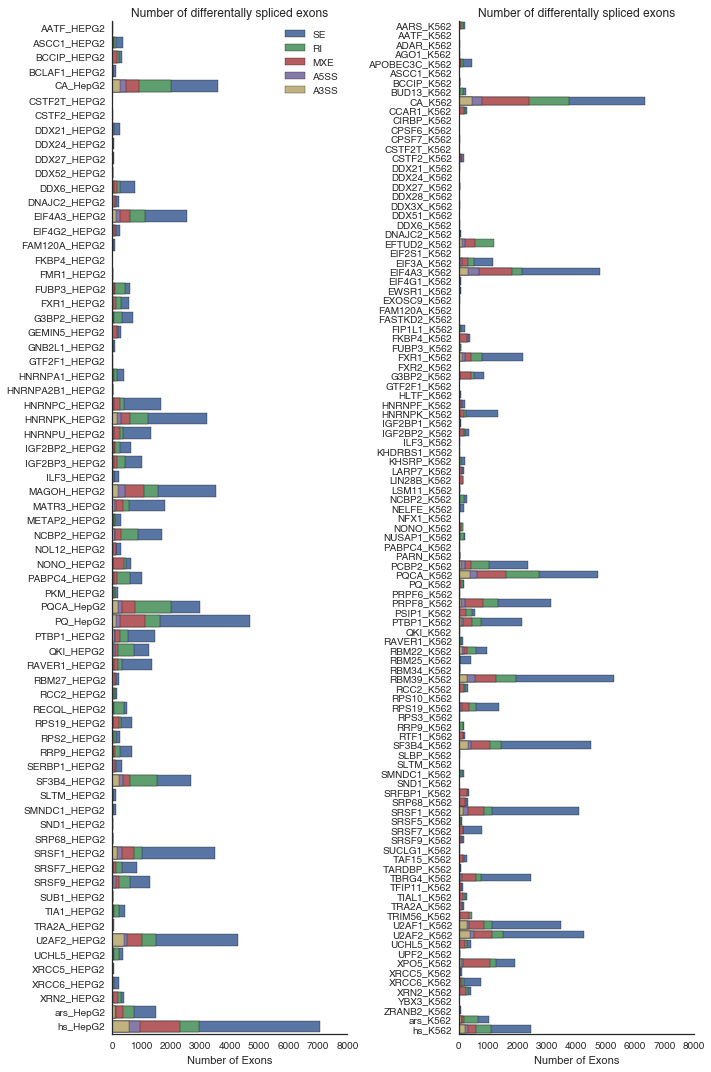

In [27]:
cumsum_num_events = combined_events_encode.cumsum(axis=1)
cumsum_num_events.index = cumsum_num_events.index.map(lambda x: id_to_name[x])
cumsum_num_events = cumsum_num_events.sort_index()

num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode.svg"), figsize=(num_cols * 5, num_rows * 15)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]
        sns.barplot(x=hepg2_cumsum[splice_type], y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        hepg2_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_yticklabels()]
        hepg2_ax.set_ylabel("")
        
        k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]

        sns.barplot(x=k562_cumsum[splice_type], y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        k562_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in k562_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in k562_ax.get_yticklabels()]
        k562_ax.set_ylabel("")

In [28]:
fraction_combined_events = combined_events.div(combined_events.sum(axis=1), axis=0)
fraction_combined_events_encode = combined_events_encode.div(combined_events_encode.sum(axis=1), axis=0)

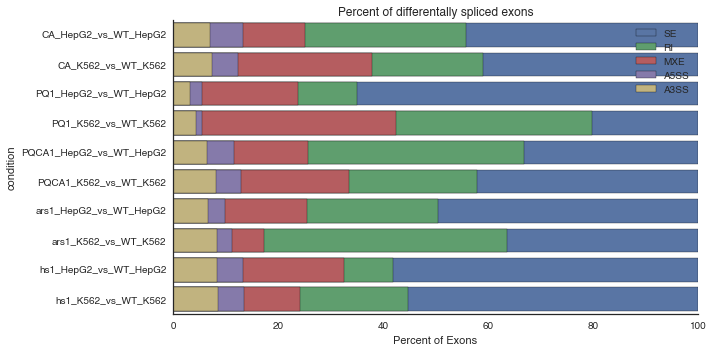

In [29]:
cumsum_fraction_combined_events = fraction_combined_events.cumsum(axis=1) * 100

with dataviz.Figure(os.path.join(heatmap_dir, "fraction_of_differentally_splice_events.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_fraction_combined_events.columns)):
        sns.barplot(x=cumsum_fraction_combined_events[splice_type], y=cumsum_fraction_combined_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Percent of differentally spliced exons")
        ax.set_xlabel("Percent of Exons")
        sns.despine(ax=ax)

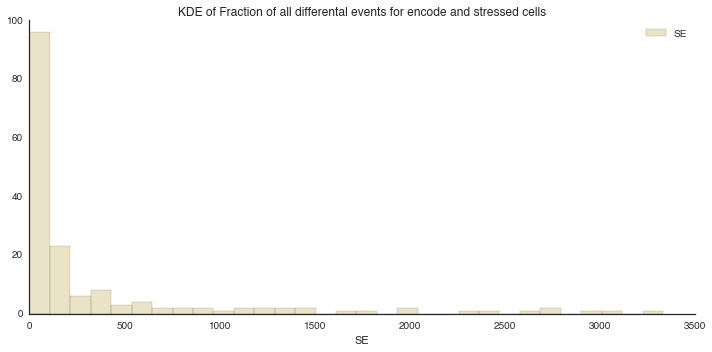

In [30]:
with dataviz.Figure(os.path.join(heatmap_dir, "encode_all_se_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    sns.distplot(combined_events_encode.ix[combined_events_encode.index.difference(sort_order)]['SE'].fillna(0), 
                 hist=True, norm_hist=False, kde=False, color=color, label='SE', ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,)
    sns.despine(ax=ax)

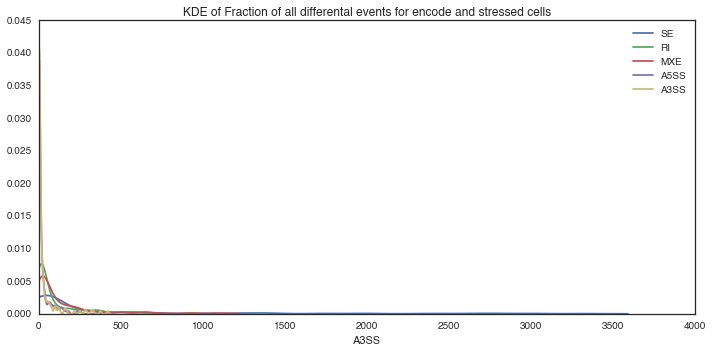

In [31]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_all_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        sns.distplot(combined_events_encode.ix[combined_events_encode.index.difference(sort_order)][splice_type].fillna(0), hist=False, color=color, label=splice_type, ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,)
    

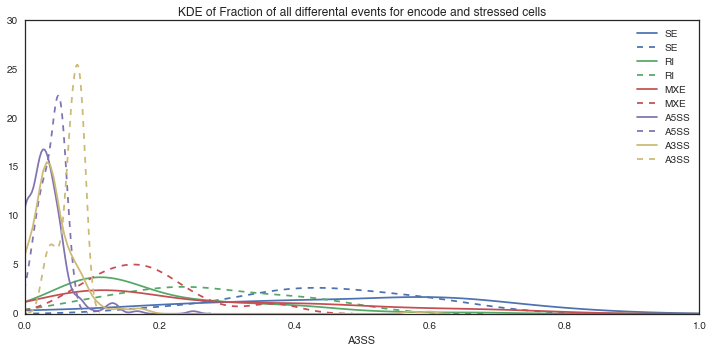

In [32]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_all_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
 
        sns.distplot(fraction_combined_events_encode[splice_type].fillna(0), hist=False, color=color, label=splice_type, ax=ax)
        sns.distplot(fraction_combined_events_encode.ix[sort_order][splice_type].fillna(0), hist=False, color=color, kde_kws ={'linestyle': "--"}, label=splice_type, ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,1)

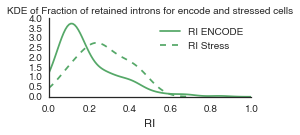

In [33]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_ri_distribution.svg"), figsize=(4, 2)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        if splice_type != "RI":
            continue
        sns.distplot(fraction_combined_events_encode[splice_type].fillna(0), hist=False, color=color, label=splice_type + " ENCODE", ax=ax)
        sns.distplot(fraction_combined_events_encode.ix[sort_order][splice_type].fillna(0), hist=False, color=color, kde_kws ={'linestyle': "--"}, label=splice_type + " Stress", ax=ax)
        ax.legend()
        ax.set_xlim(0,1)
        ax.set_title("KDE of Fraction of retained introns for encode and stressed cells", fontsize=10)
        sns.despine(ax=ax)

In [34]:
fraction_cryptic_events = se_sig_stress_events[se_sig_stress_events.is_cryptic].groupby(level=["direction", "condition"]).count().GeneID.unstack().T / se_sig_stress_events.groupby(level=["direction", "condition"]).count().GeneID.unstack().T
fraction_cryptic_events

direction                excluded  included
condition                                  
CA_HepG2_vs_WT_HepG2     0.578339  0.218266
CA_K562_vs_WT_K562       0.615385  0.260093
PQ1_HepG2_vs_WT_HepG2    0.478453  0.419048
PQ1_K562_vs_WT_K562      0.538462  0.400000
PQCA1_HepG2_vs_WT_HepG2  0.481424  0.300000
PQCA1_K562_vs_WT_K562    0.621849  0.273412
ars1_HepG2_vs_WT_HepG2   0.677711  0.264851
ars1_K562_vs_WT_K562     0.567901  0.337900
hs1_HepG2_vs_WT_HepG2    0.740453  0.239680
hs1_K562_vs_WT_K562      0.572897  0.312925

In [35]:
se_sig_stress_events['direction'] = se_sig_stress_events.index.get_level_values(level=0)

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


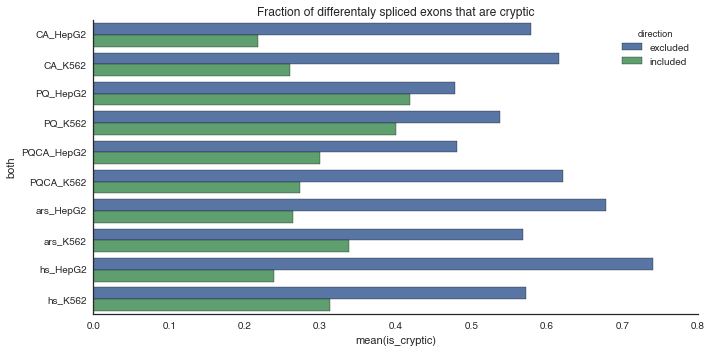

In [36]:
#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "fraction_cryptic_events_stress.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Fraction of differentaly spliced exons that are cryptic")
 
    sns.barplot(x="is_cryptic", y="both", hue="direction", data=se_sig_stress_events, ci=False,
               ax=ax)
    sns.despine(ax=ax)

Check cryptic exons make sure they have splicing signal GT AG

#look for stress response genes in the different stressors
chaperones for PQ

In [37]:
#Do all the combinations, but it takes forever, so I leave this commented out

# sig_rMATS = se[se.FDR < .05].copy()

# sig_rMATS['upstreamES'] = sig_rMATS.upstreamES.astype(int)
# sig_rMATS['upstreamEE'] = sig_rMATS.upstreamEE.astype(int)
# sig_rMATS['exonStart_0base'] = sig_rMATS.exonStart_0base.astype(int)
# sig_rMATS['exonEnd'] = sig_rMATS.exonEnd.astype(int)
# sig_rMATS['downstreamES'] = sig_rMATS.downstreamES.astype(int)
# sig_rMATS['downstreamEE'] = sig_rMATS.downstreamEE.astype(int)

# sig_rMATS['event_name'] = sig_rMATS.apply(splicing_map.mats_reformat_geneid, axis=1)
# sig_rMATS['direction'] = sig_rMATS.apply(splicing_map.mats_get_direction, axis=1)
# sig_rMATS['P-value'] = sig_rMATS.PValue

# for stress_name, df in sig_rMATS.groupby(level=0):
#     for name, row in master_processing_table.iterrows():
#         uid = row.UID
#         rbp = row.RBP_gID
#         cell_type = row.CellLine

#         try:
#             read_density = splicing_map.ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_01_{}.merged.r2.norm.neg.bw".format(uid, rbp), 
#                                        neg="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_01_{}.merged.r2.norm.pos.bw".format(uid, rbp))

#             splicing_map.plot_splice_map(read_density, df, "{} {} {} Rep 1".format(stress_name, rbp, cell_type),  os.path.join(img_dir, "{}_{}_01_{}.splice_map.svg".format(stress_name, uid, rbp)))

#             read_density = splicing_map.ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_02_{}.merged.r2.norm.neg.bw".format(uid, rbp), 
#                                        neg="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_02_{}.merged.r2.norm.pos.bw".format(uid, rbp))

#             splicing_map.plot_splice_map(read_density, df, "{} {} {} Rep 2".format(stress_name, rbp, cell_type),  os.path.join(img_dir, "{}_{}_02_{}.splice_map.svg".format(stress_name, uid, rbp)))

#         except Exception as e:
#             print e
#             print uid, rbp, cell_type

#Encode differental splicing

In [38]:
foo = all_sig_events.groupby(level=["event_type", "direction", 'both']).count().GeneID.unstack().T

In [39]:
#HTML(all_sig_events.groupby(level=["event_type", "direction", 'both']).count().GeneID.unstack().T.to_html())

In [40]:
#foo.sort_values(("SE", "excluded"), ascending=False).head()

In [41]:
#foo.sort_values(("SE", "included"), ascending=False).head()

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


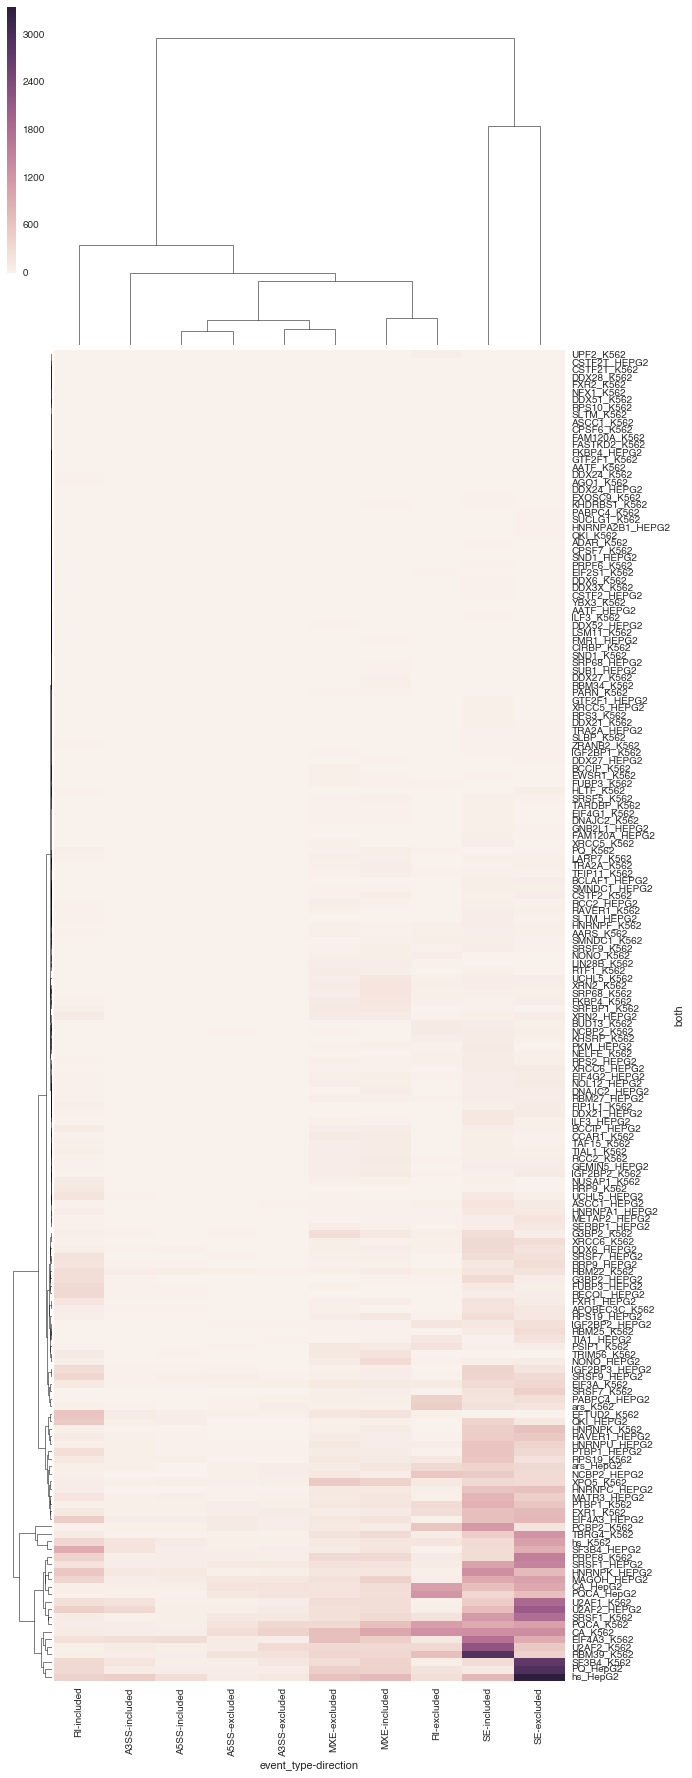

In [42]:
sns.clustermap(foo.fillna(0), figsize=(10, 30))

#How about RBPs proximal to splicing events (the damn splicing graphs are too hard to read)

In [43]:
names = ['cryptic_chrom', 'cryptic_start', "cryptic_stop", 'cryptic_name',
         'rbp_chrom', 'rbp_start', 'rbp_stop', 'rbp_name', 'rbp_score', 'rbp_strand', "rbp_foo", 'rbp_bar', 'rbp_color', 'foo', 'bar', 'baz', 'buz']

master_peaks = {"K562":  pybedtools.BedTool("/home/gpratt/Dropbox/cryptic_splicing/data/clip/encode_v12_filelist.allencode_20160226.txt.K562_allpeaks_ENCODEv12.colored.bed").sort().saveas(),
                "HEPG2":  pybedtools.BedTool("/home/gpratt/Dropbox/cryptic_splicing/data/clip/encode_v12_filelist.allencode_20160226.txt.HepG2_allpeaks_ENCODEv12.colored.bed").sort().saveas()}

In [44]:
def convert_to_bedtool_internal(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['exonStart_0base']), 
                                                             int(row['exonEnd']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

def convert_to_bedtool_upstream(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['upstreamES']),
                                                             int(row['upstreamEE']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

def convert_to_bedtool_downstream(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['downstreamES']), 
                                                             int(row['downstreamEE']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

In [45]:
def get_bound_exons(events):
    result_internal = {}
    result_upstream = {}
    result_downstream = {}

    for cell_type, df in events.ix["SE"].dropna(how="all", axis=1).groupby(level="cell_type"):
        bedtool_internal = convert_to_bedtool_internal(df)    
        bedtool_upstream = convert_to_bedtool_upstream(df)    
        bedtool_downstream = convert_to_bedtool_downstream(df)    

        overlapped_bedtool = bedtool_internal.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_internal[cell_type] = cryptic_events_slop_counts.unstack()    

        overlapped_bedtool = bedtool_upstream.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_upstream[cell_type] = cryptic_events_slop_counts.unstack()   

        overlapped_bedtool = bedtool_downstream.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_downstream[cell_type] = cryptic_events_slop_counts.unstack()   

    result_internal = pd.concat(result_internal, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
    result_upstream = pd.concat(result_upstream, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
    result_downstream = pd.concat(result_downstream, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
   
    return result_internal, result_upstream, result_downstream

In [ ]:
result_internal, result_upstream, result_downstream = get_bound_exons(all_sig_events)
result_background_internal, result_background_upstream, result_background_downstream = get_bound_exons(background_events)

In [41]:
#fraction of events that are bound proximally by RBP
fraction_internal_bound = (result_internal > 0).groupby(level='both').sum().div(result_internal.groupby(level='both').apply(len), axis=0)
fraction_internal_background_bound = (result_background_internal > 0).groupby(level='both').sum().div(result_background_internal.groupby(level='both').apply(len), axis=0)

internal_fraction_enriched = np.log2(fraction_internal_bound.fillna(0) / fraction_internal_background_bound.fillna(0))
internal_fraction_enriched[internal_fraction_enriched.applymap(np.isneginf)] = 0
internal_fraction_enriched[internal_fraction_enriched.applymap(np.isinf)] = 0
internal_fraction_enriched = internal_fraction_enriched.fillna(0)

In [48]:
internal_fraction_enriched.index = pd.MultiIndex.from_tuples(internal_fraction_enriched.index.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])

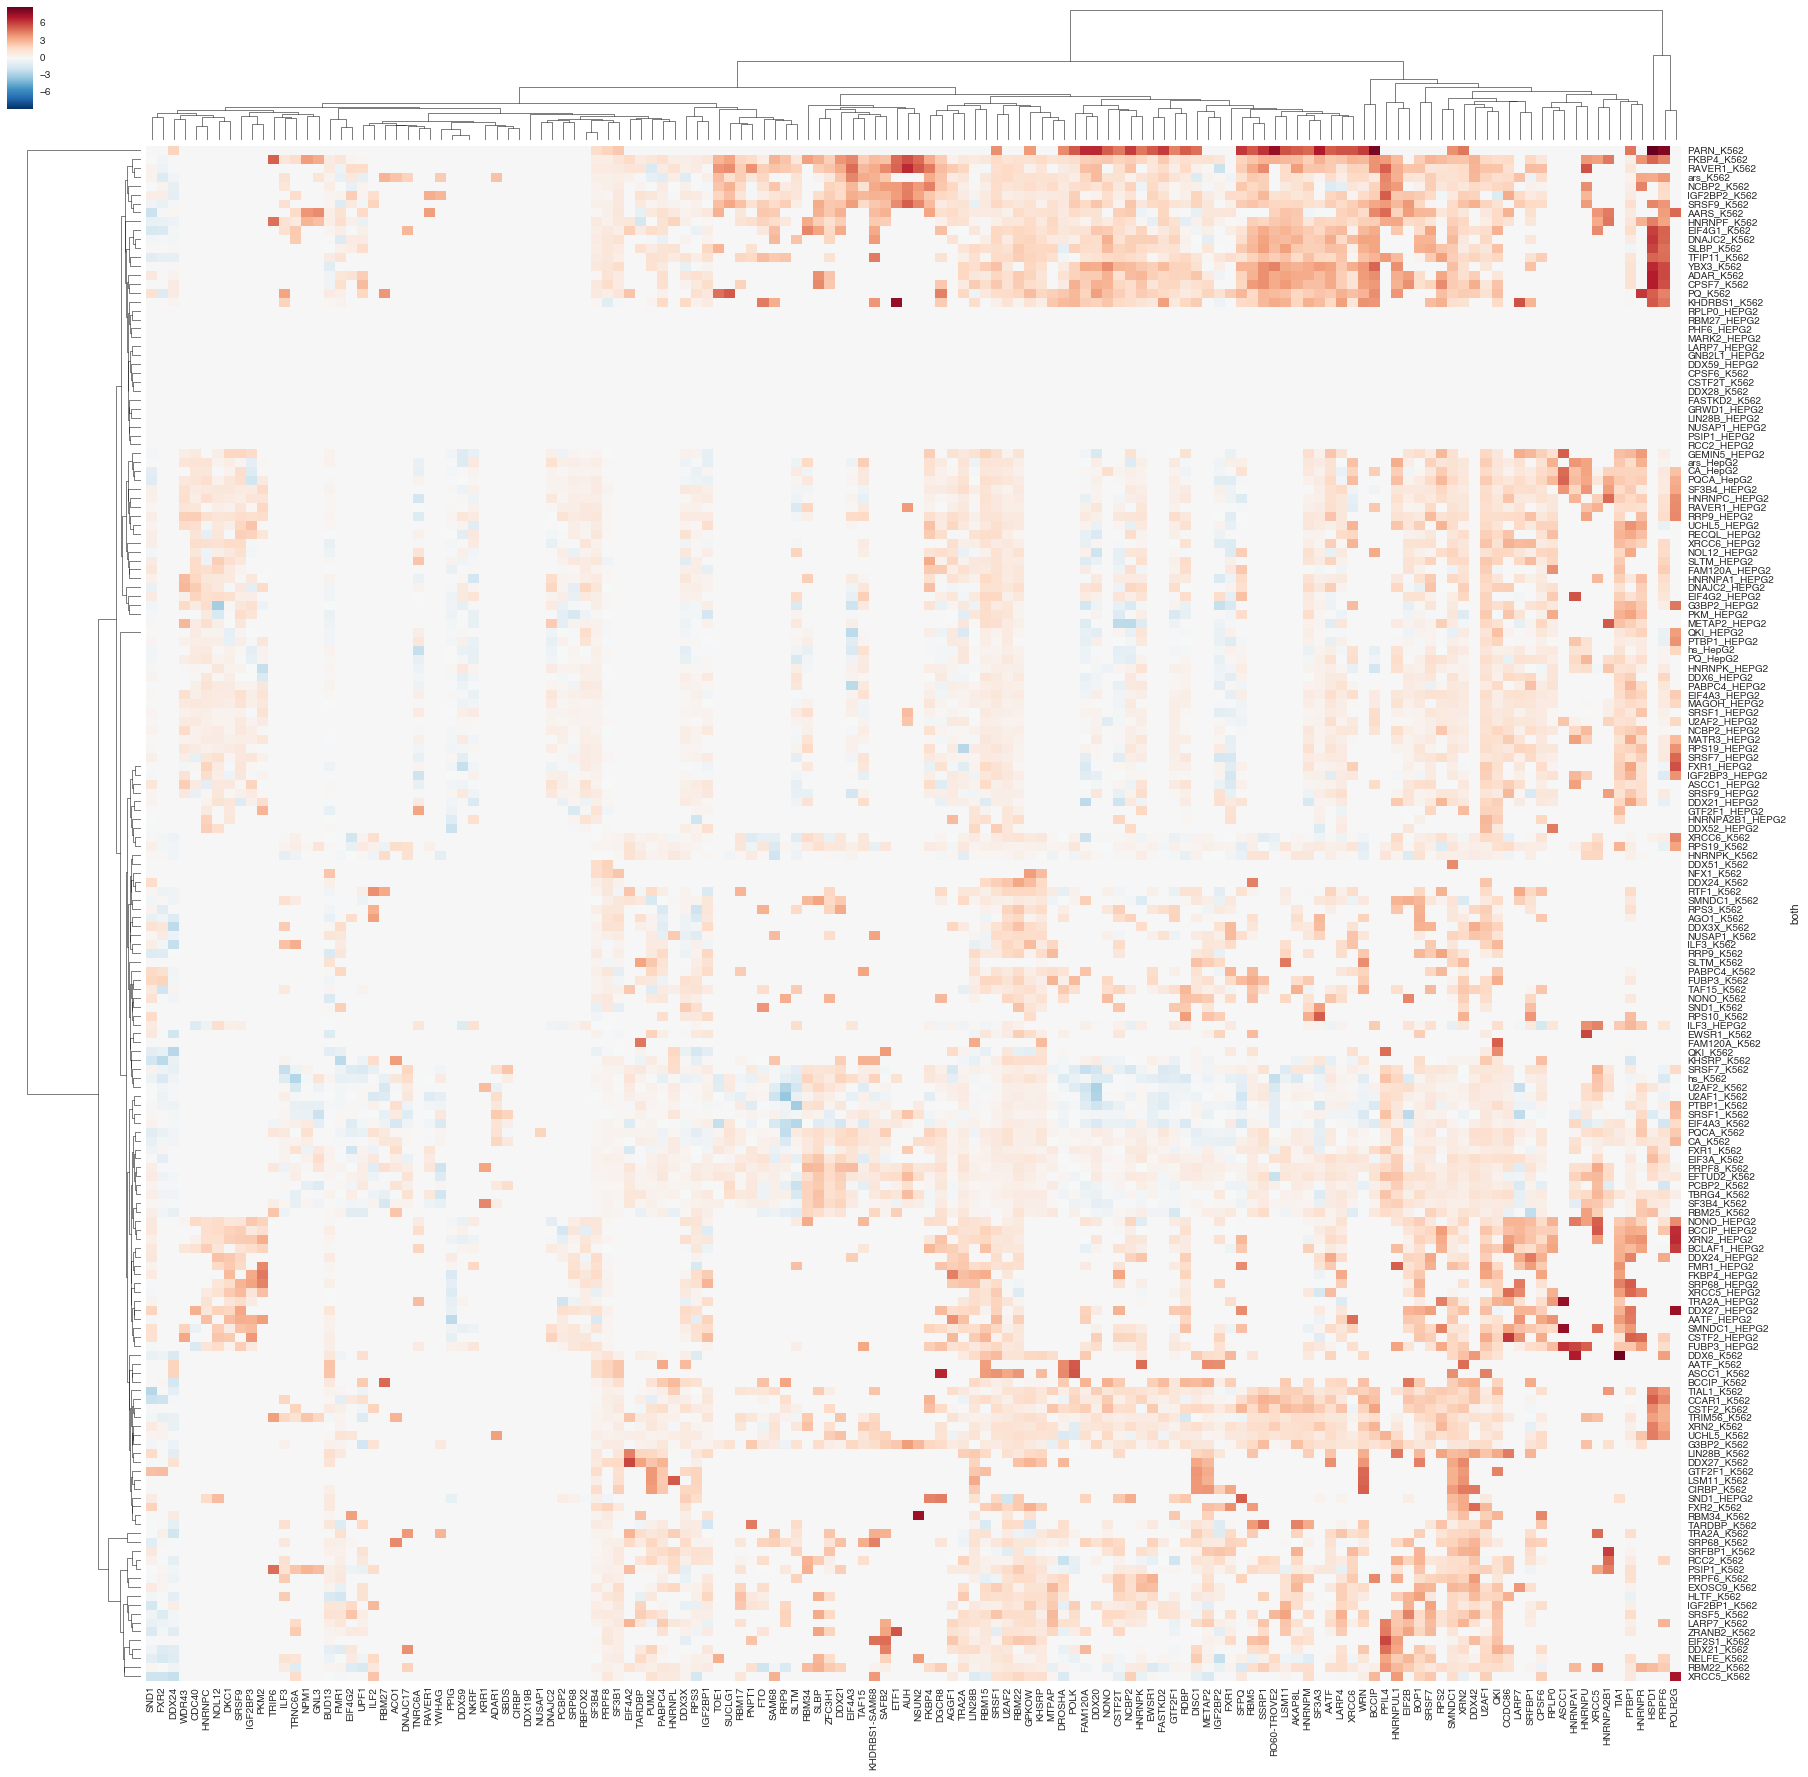

In [42]:
sns.clustermap(internal_fraction_enriched, figsize=(30,30))
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.pdf"))

This is cool, but doesn't tell me much yet, enriched and non-enriched genes in total, lets see if there are some super responsive RBPs

In [58]:
stress_conditions = ['CA', 'PQ', 'PQCA', 'hs', 'ars']

In [78]:
internal_fraction_enriched_k562 = internal_fraction_enriched.xs("K562", level=1)
internal_fraction_enriched_k562 = internal_fraction_enriched_k562[(internal_fraction_enriched_k562.sum() != 0).index]
internal_fraction_enriched_k562 = internal_fraction_enriched_k562.T.ix[internal_fraction_enriched_k562.sum() != 0].T

internal_fraction_enriched_hepg2 = internal_fraction_enriched.xs("HepG2", level=1)
internal_fraction_enriched_hepg2 = internal_fraction_enriched_hepg2[(internal_fraction_enriched_hepg2.sum() != 0).index]
internal_fraction_enriched_hepg2 = internal_fraction_enriched_hepg2.T.ix[internal_fraction_enriched_hepg2.sum() != 0].T


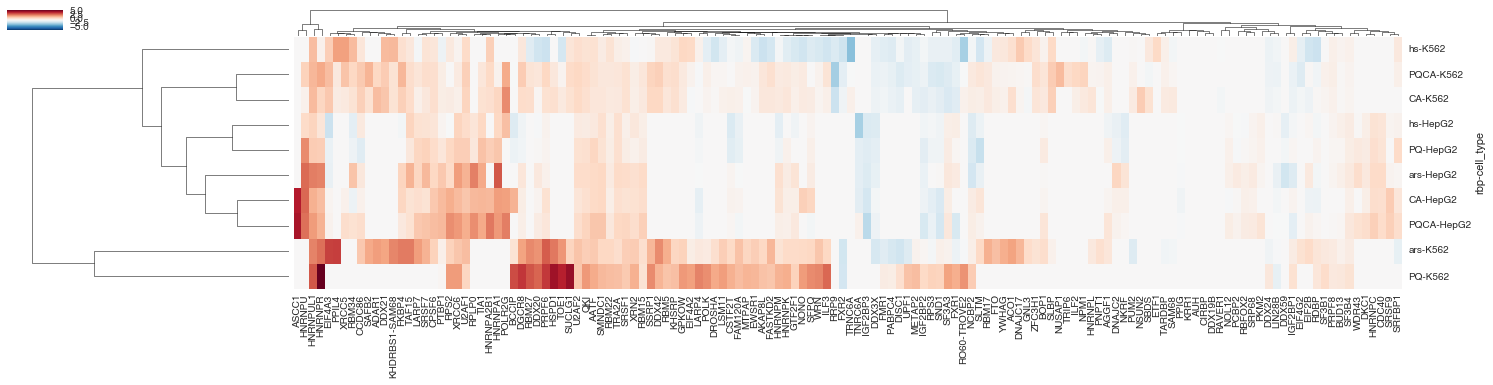

In [60]:
sns.clustermap(internal_fraction_enriched.ix[stress_conditions].fillna(0), figsize=(25,5))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched.pdf"))

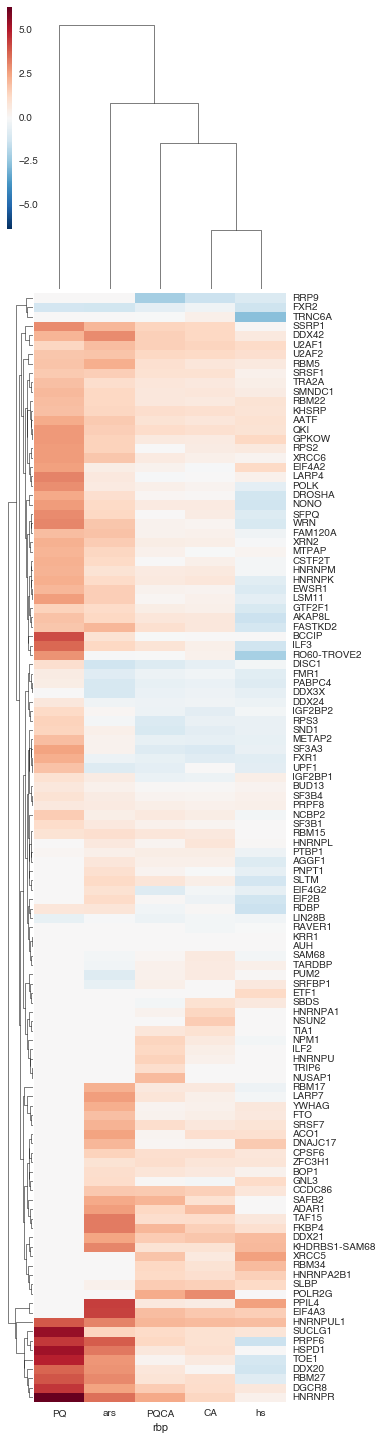

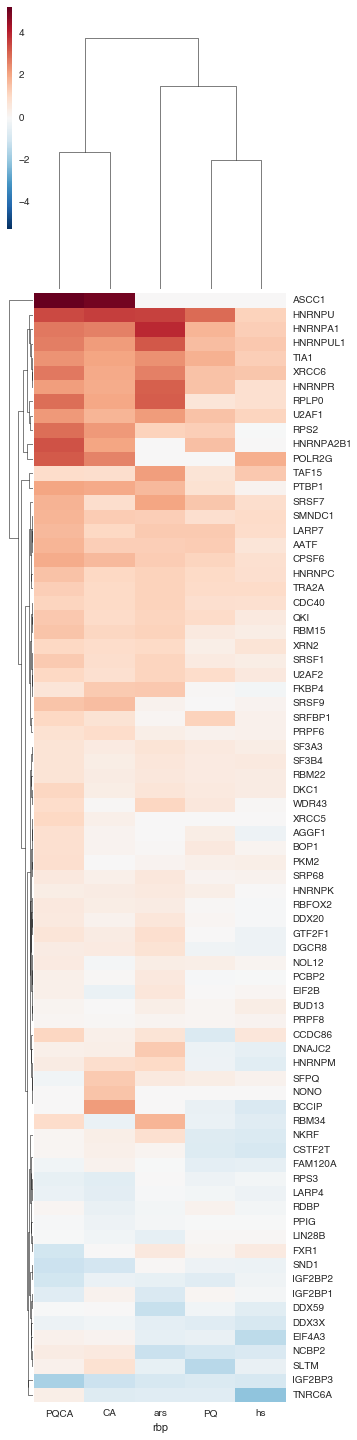

In [79]:
sns.clustermap(internal_fraction_enriched_k562.ix[stress_conditions].T.fillna(0), figsize=(5,25))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_k562.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_k562.pdf"))

sns.clustermap(internal_fraction_enriched_hepg2.ix[stress_conditions].T.fillna(0), figsize=(5,25))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_hepg2.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_hepg2.pdf"))

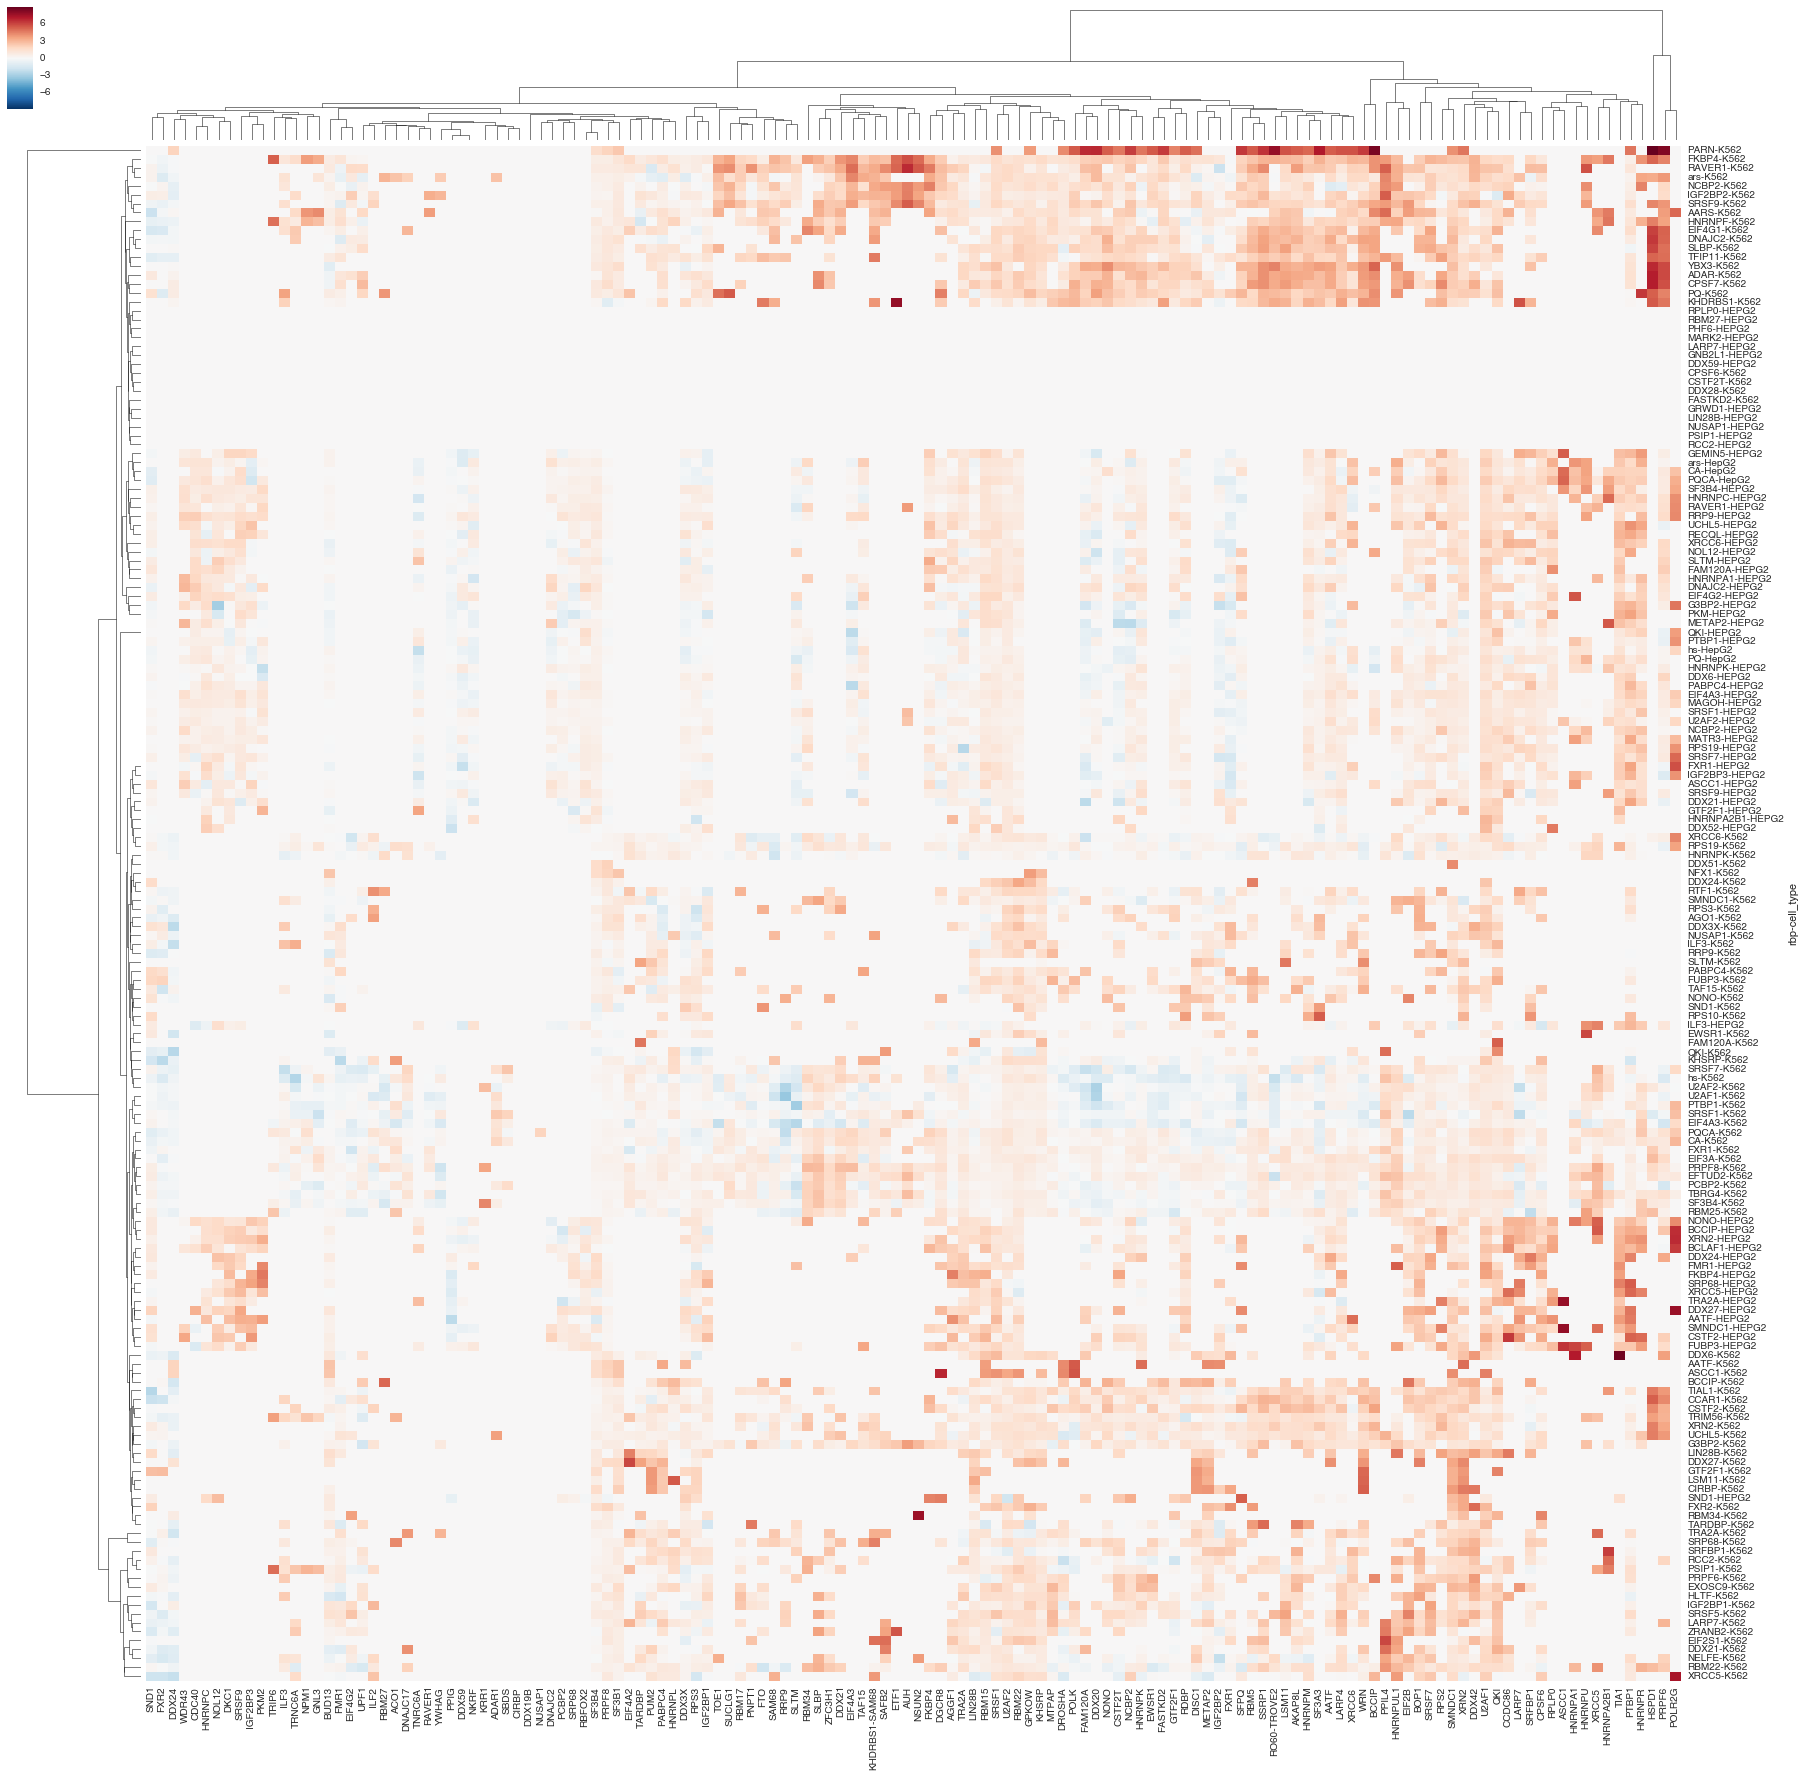

In [62]:
sns.clustermap(internal_fraction_enriched, figsize=(30,30))
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.pdf"))

In [80]:
overlapping_genes = internal_fraction_enriched.columns & internal_fraction_enriched.index.levels[0]

result = {}
for rbp in overlapping_genes:
    result[rbp] = internal_fraction_enriched[rbp].ix[rbp]
specific_enrichment = pd.concat(result)

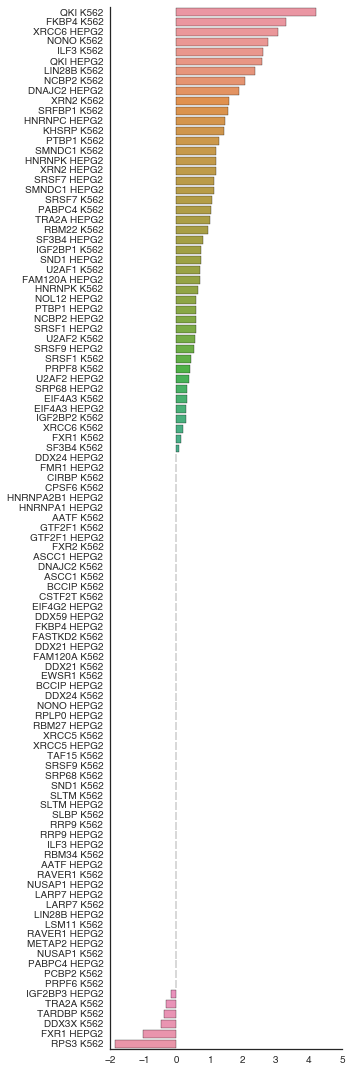

In [81]:
with dataviz.Figure(os.path.join(heatmap_dir, "responsive_factors.svg"), figsize=(5, 15)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.barplot(x=specific_enrichment.sort_values(ascending=False), 
                y=specific_enrichment.sort_values(ascending=False).index.map(lambda x: " ".join(x)),
               ax=ax)
    sns.despine(ax=ax)

QKI is responisvie, which is a good positive control, but other things not known to be splicing factors also are, thats kind of interesting

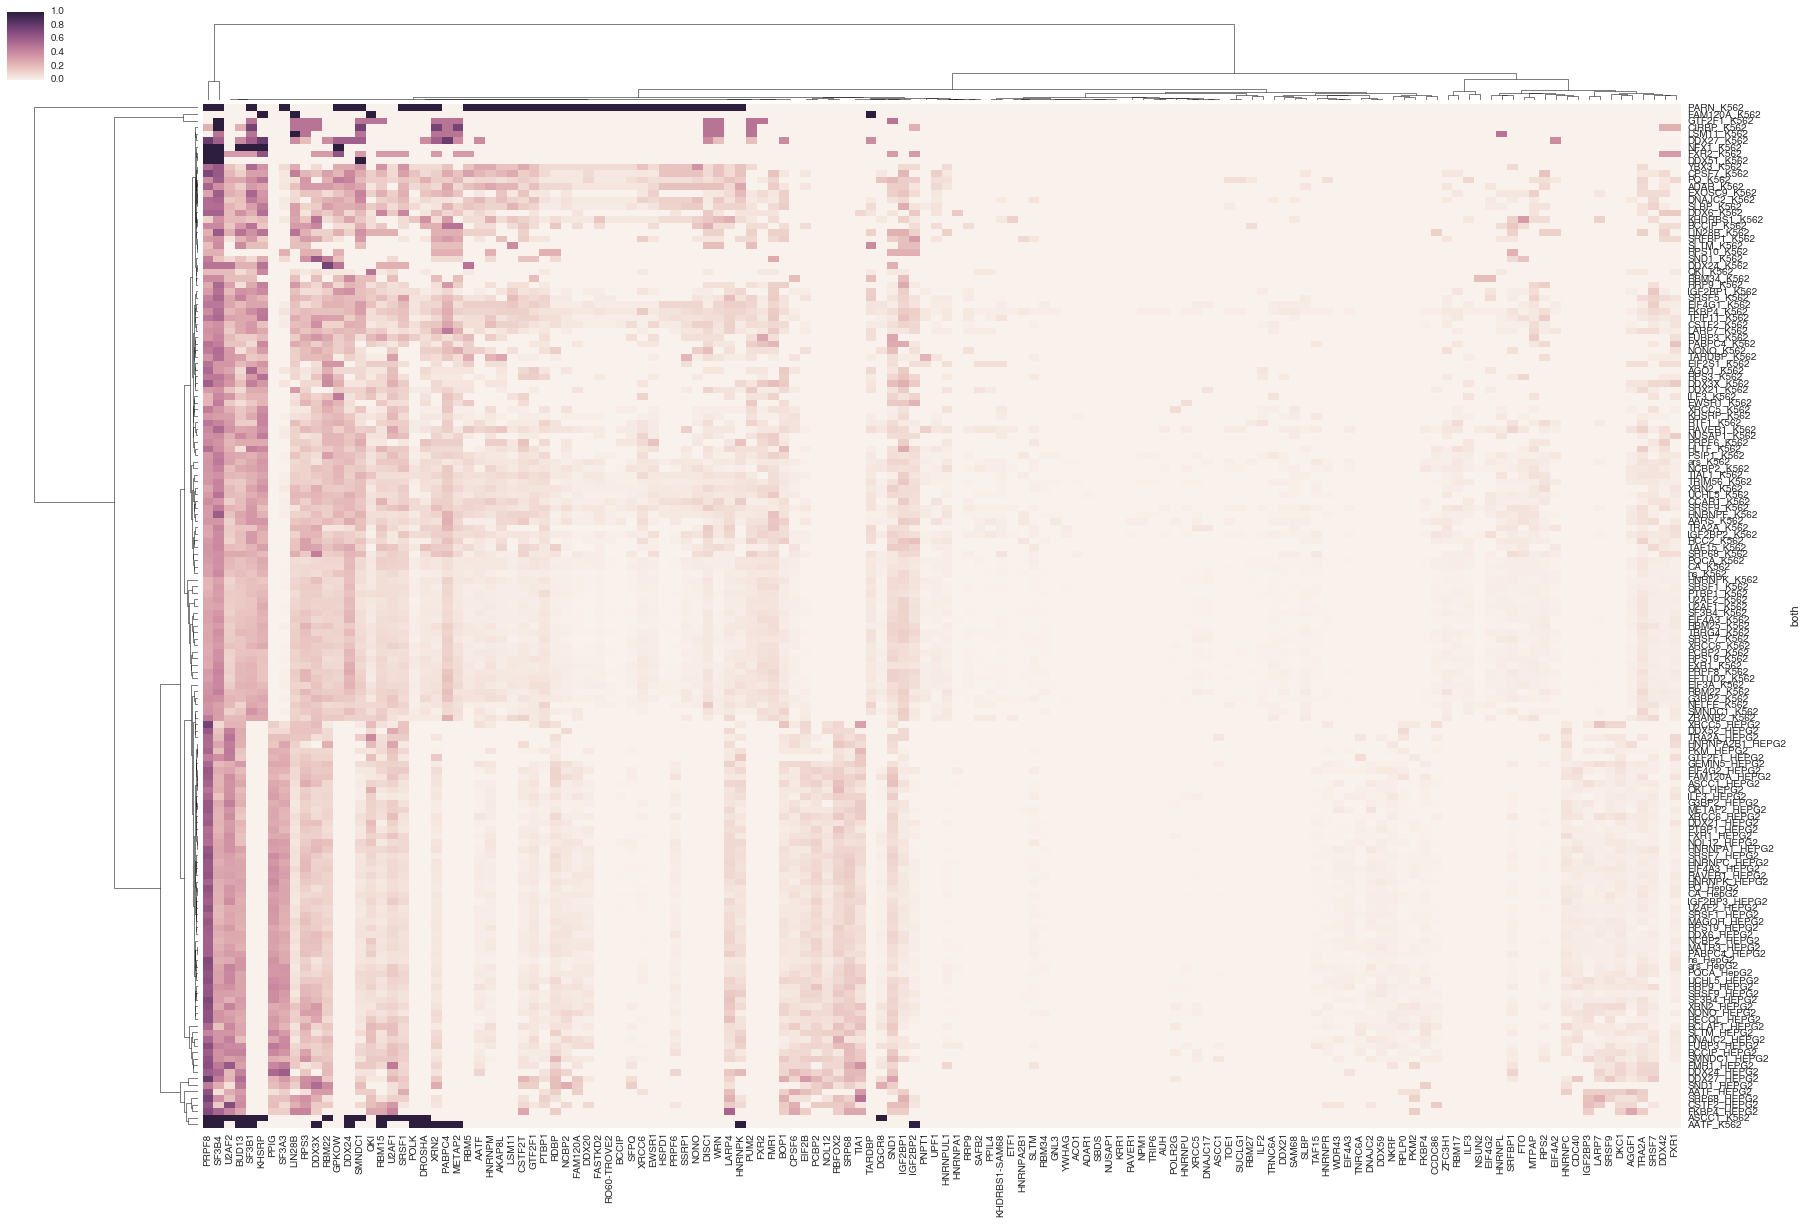

In [82]:
sns.clustermap(fraction_internal_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_encode.pdf"))

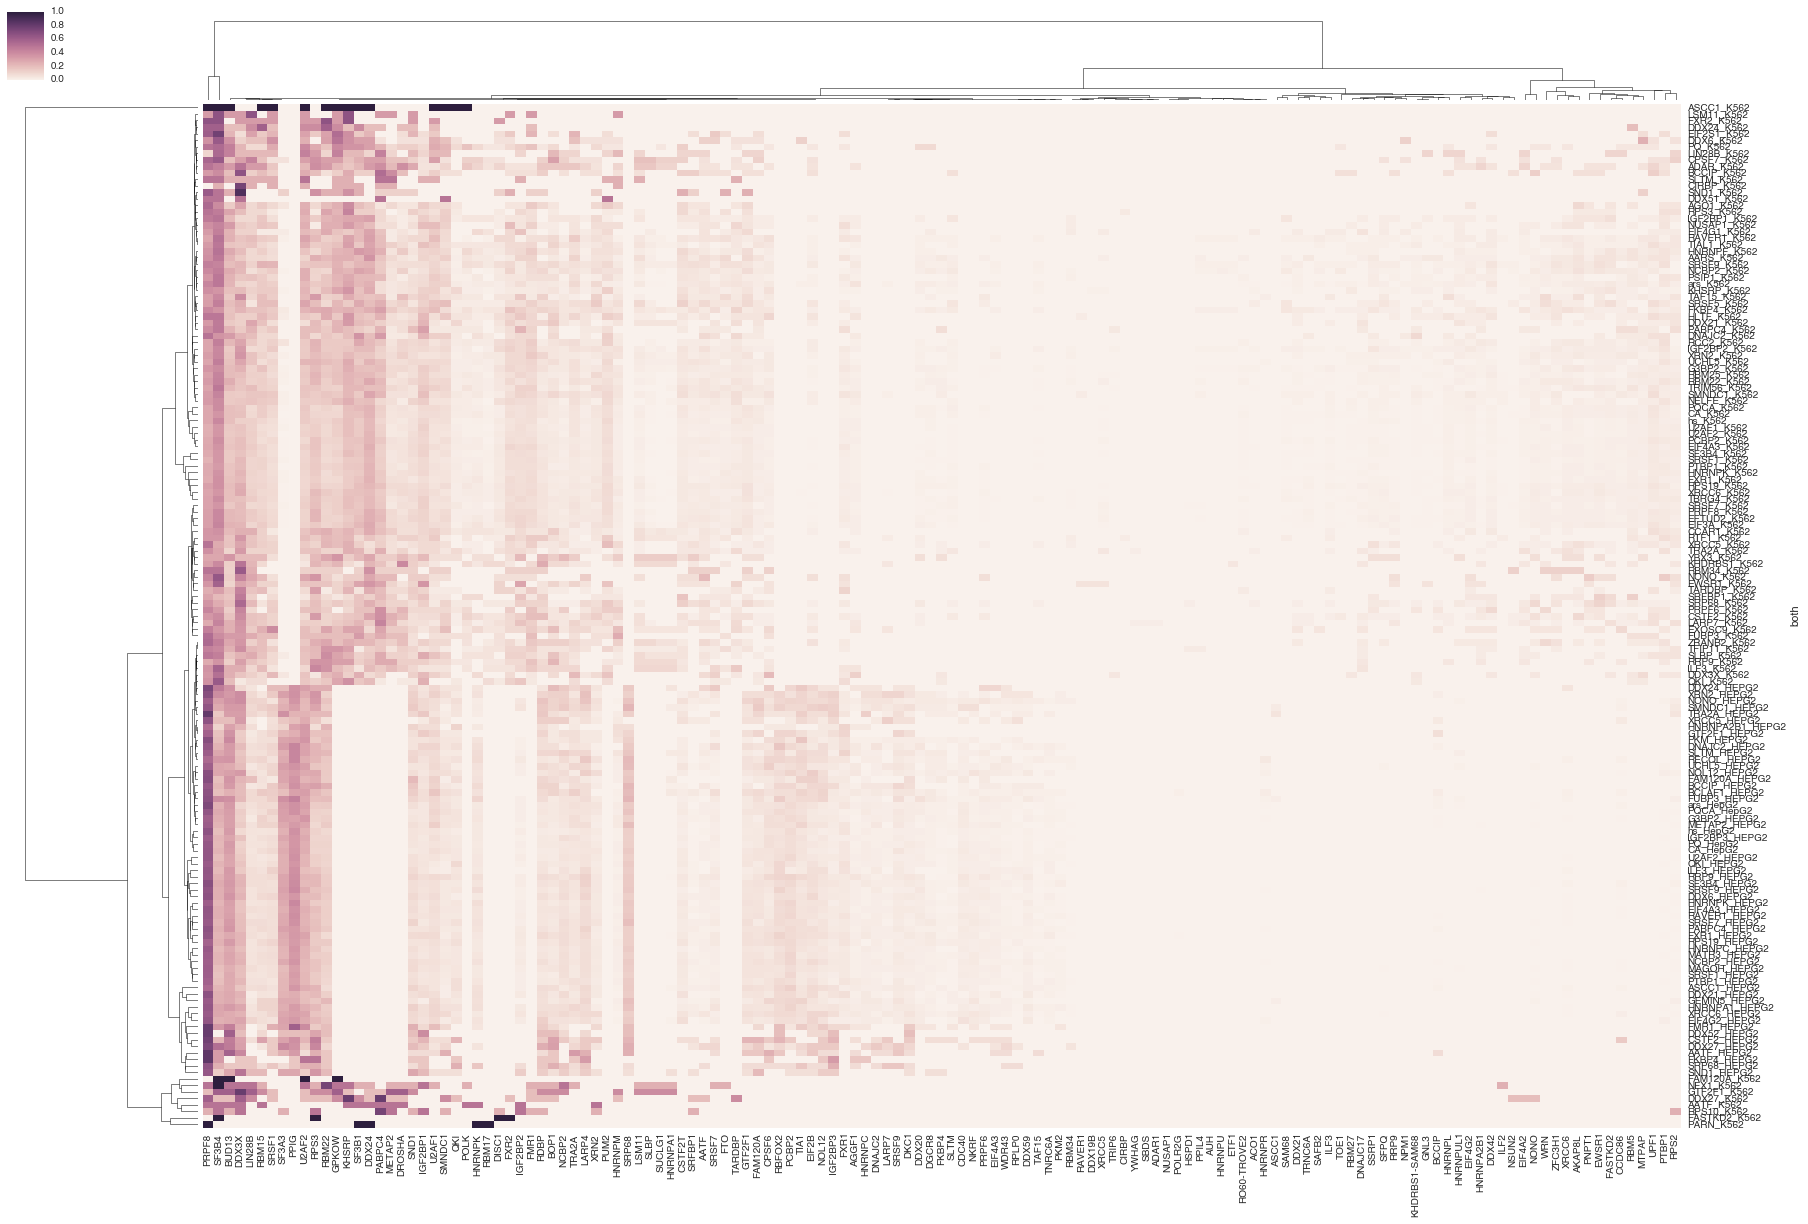

In [83]:
#fraction of events that are bound proximally by RBP
fraction_bound = (result_upstream > 0).groupby(level='both').sum().div(result_upstream.groupby(level='both').apply(len), axis=0)
sns.clustermap(fraction_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "upstream_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "upstream_encode.pdf"))

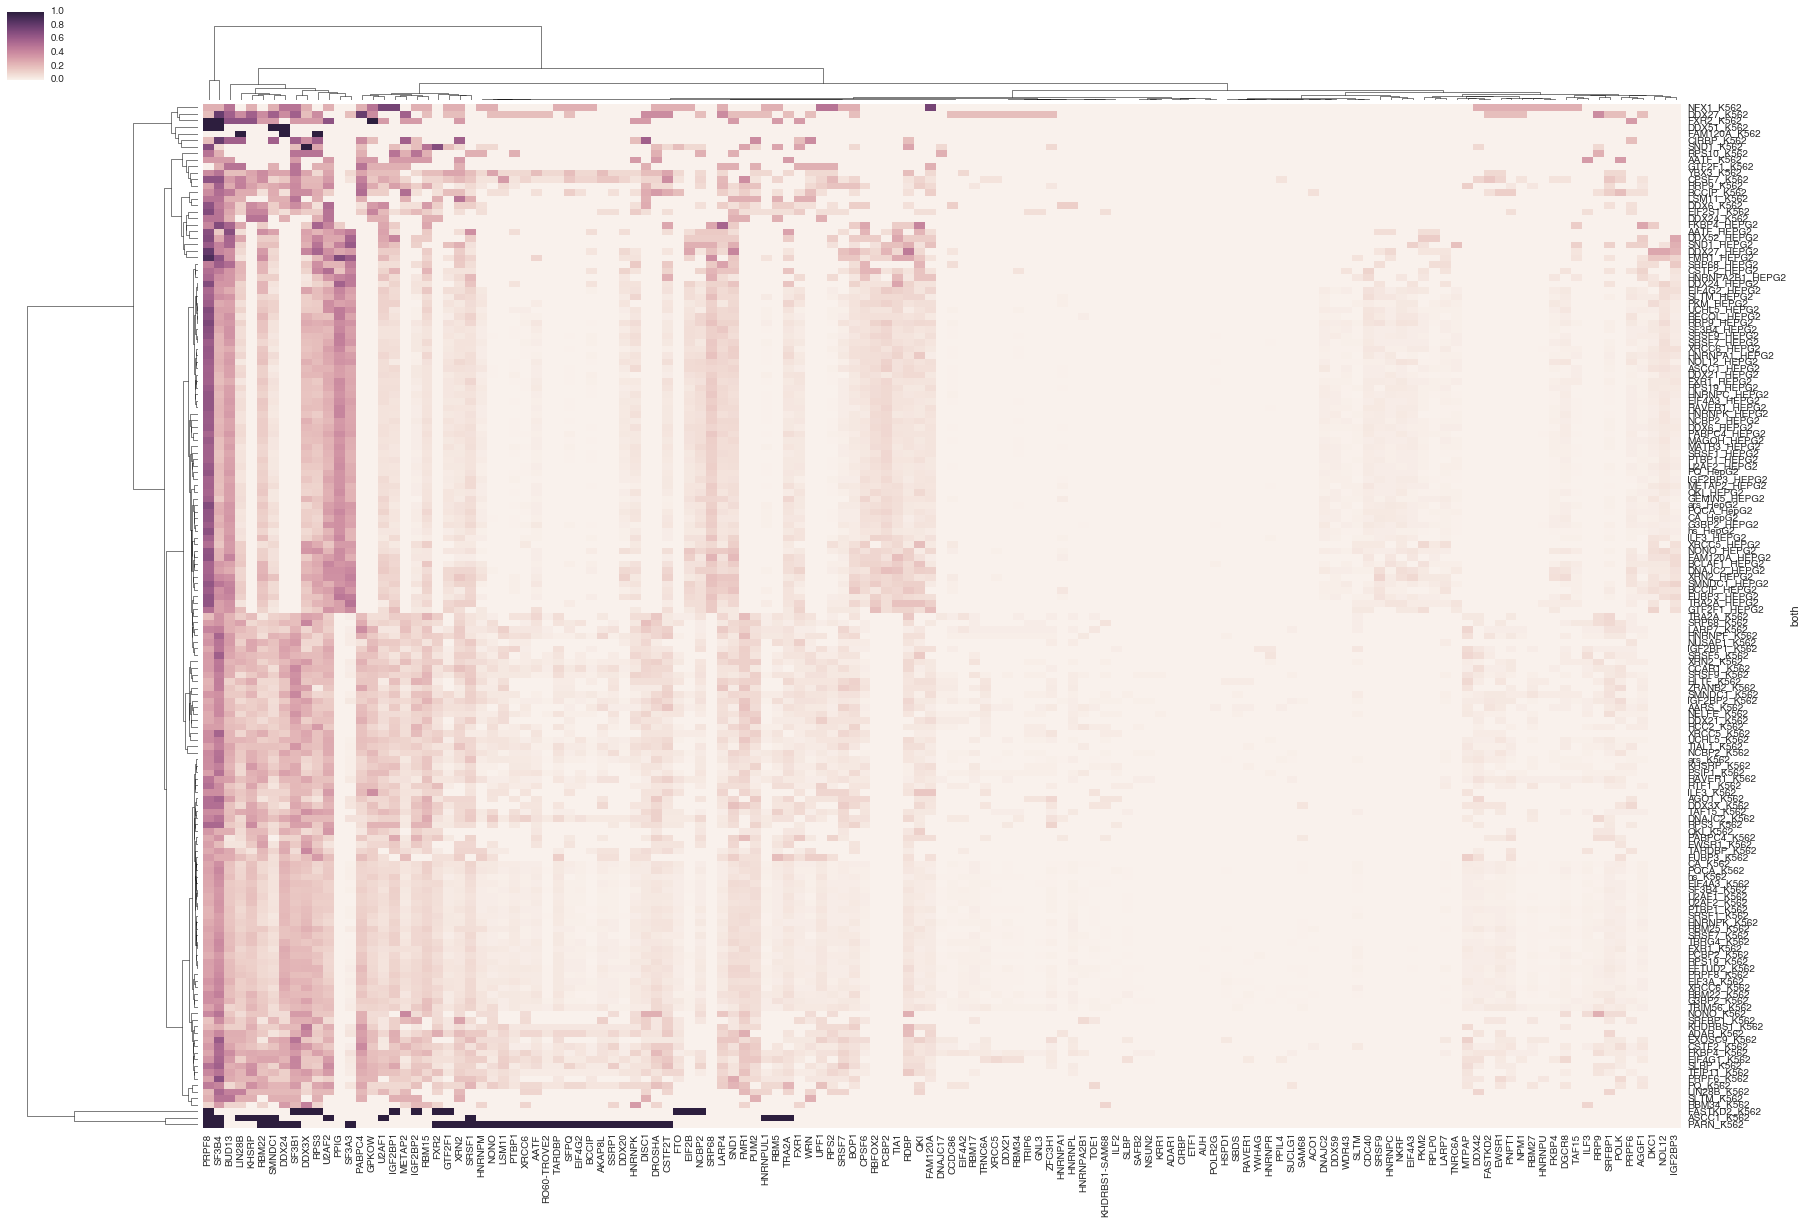

In [84]:
#fraction of events that are bound proximally by RBP
fraction_bound = (result_downstream > 0).groupby(level='both').sum().div(result_downstream.groupby(level='both').apply(len), axis=0)
sns.clustermap(fraction_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "downstream_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "downstream_encode.pdf"))

#How about for Stressed exons?

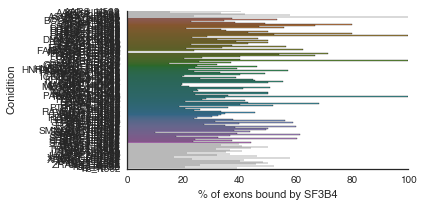

In [85]:
#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "SF3B4_included.svg"), figsize=(6, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(y=[item.split("_vs")[0] for item in fraction_bound['SF3B4'].index], 
                x=fraction_bound['SF3B4'].values * 100, ax=ax, orient="h")
    ax.set_xlabel("% of exons bound by SF3B4")
    ax.set_ylabel("Conidition")
    sns.despine(ax=ax)

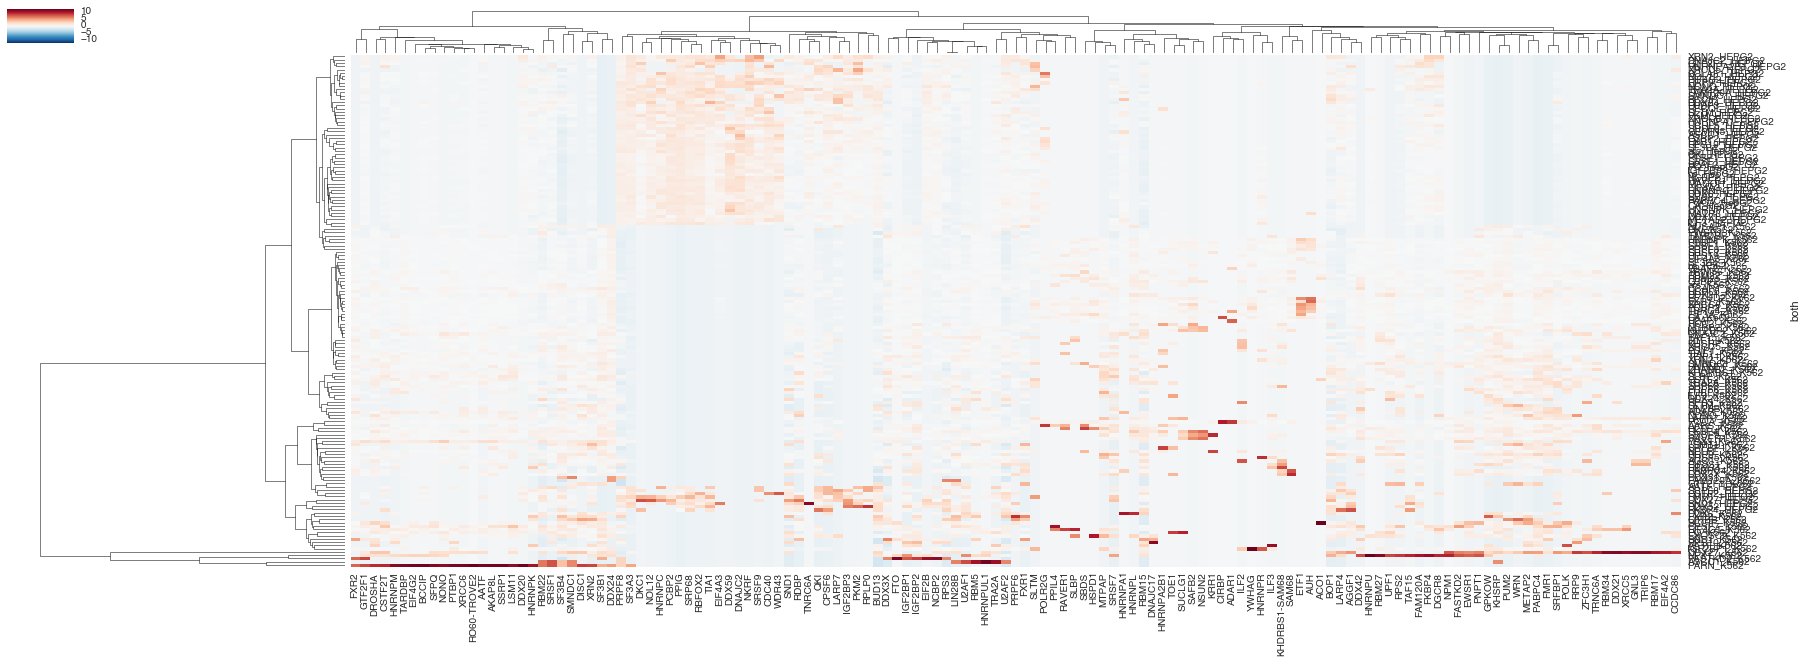

In [88]:
sns.clustermap((fraction_bound - fraction_bound.mean()) / fraction_bound.std(), figsize=(30,10))


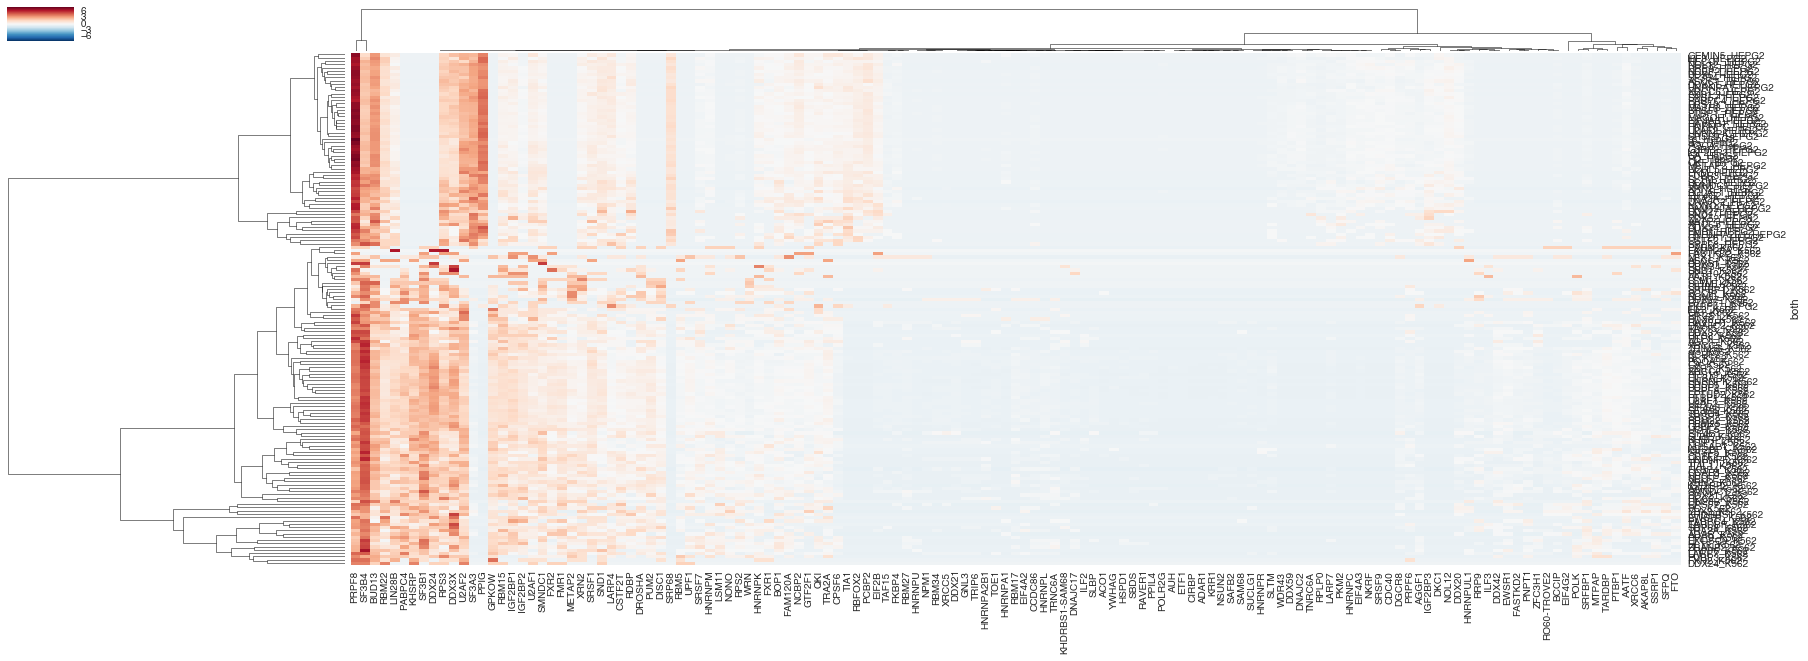

In [89]:
sns.clustermap((fraction_bound.sub(fraction_bound.mean(axis=1), axis=0)).div(fraction_bound.std(axis=1), axis=0), figsize=(30,10))

#ok now for the hard part, figure out how to get co-occuring splicing events

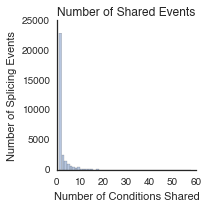

In [217]:
all_sig_se_events = all_sig_events.xs("SE").dropna(how="all", axis=1)

#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_events.svg"), figsize=(3, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.distplot(all_sig_se_events.groupby("group_id").count().FDR, kde=False, norm_hist=False, ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")

In [92]:
Counter(se_events.groupby("group_id").count().FDR)
#There aren't a bunch of conserved splicing events between everything, but there are a bunch of pairwise events

Counter({1: 17340, 2: 5508, 3: 2531, 4: 1444, 5: 941, 6: 628, 7: 413, 8: 354, 9: 274, 10: 218, 11: 129, 12: 117, 13: 99, 14: 64, 15: 61, 16: 46, 17: 38, 18: 36, 19: 29, 21: 24, 20: 18, 22: 13, 24: 10, 23: 9, 25: 8, 27: 8, 31: 8, 28: 7, 26: 6, 34: 5, 32: 4, 29: 3, 39: 3, 30: 2, 33: 2, 35: 2, 47: 2, 50: 2, 53: 2, 37: 1, 42: 1, 45: 1, 46: 1, 51: 1, 52: 1, 54: 1, 56: 1, 58: 1})

#How many splicing events are shared between each experiment?

In [218]:
#Jaccard and regular overlap Calculation
#Columns are the denominator
jaccard_matrix = defaultdict(dict)
fraction_matrix = defaultdict(dict)
shared_matrix = defaultdict(dict)

se_swapped = all_sig_se_events.swaplevel(0,1)
for condition_1, condition_2 in itertools.product(se_swapped.index.levels[0], se_swapped.index.levels[0]):
    overlapped = pd.concat([se_swapped.ix[condition_1], se_swapped.ix[condition_2]])
    shared_count = (overlapped.groupby("group_id").count() >= 2).sum().FDR

    jaccard_matrix[condition_1][condition_2] = shared_count / (len(overlapped.groupby("group_id").count()) * 1.0)
    fraction_matrix[condition_1][condition_2] = shared_count / (len(se_swapped.ix[condition_1]) * 1.0)
    shared_matrix[condition_1][condition_2] = shared_count
    
jaccard_matrix = pd.DataFrame(jaccard_matrix)
jaccard_matrix[jaccard_matrix.applymap(np.isneginf)] = 0
jaccard_matrix[jaccard_matrix.applymap(np.isinf)] = 0
jaccard_matrix = jaccard_matrix.fillna(0)

fraction_matrix = pd.DataFrame(fraction_matrix)
fraction_matrix[fraction_matrix.applymap(np.isneginf)] = 0
fraction_matrix[fraction_matrix.applymap(np.isinf)] = 0
fraction_matrix = fraction_matrix.fillna(0)

shared_matrix = pd.DataFrame(shared_matrix)
shared_matrix[shared_matrix.applymap(np.isneginf)] = 0
shared_matrix[shared_matrix.applymap(np.isinf)] = 0
shared_matrix = shared_matrix.fillna(0)

In [219]:
jaccard_matrix.index = jaccard_matrix.index.map(lambda x: id_to_name[x])
jaccard_matrix.columns = jaccard_matrix.columns.map(lambda x: id_to_name[x])

fraction_matrix.index = fraction_matrix.index.map(lambda x: id_to_name[x])
fraction_matrix.columns = fraction_matrix.columns.map(lambda x: id_to_name[x])

shared_matrix.index = shared_matrix.index.map(lambda x: id_to_name[x])
shared_matrix.columns = shared_matrix.columns.map(lambda x: id_to_name[x])

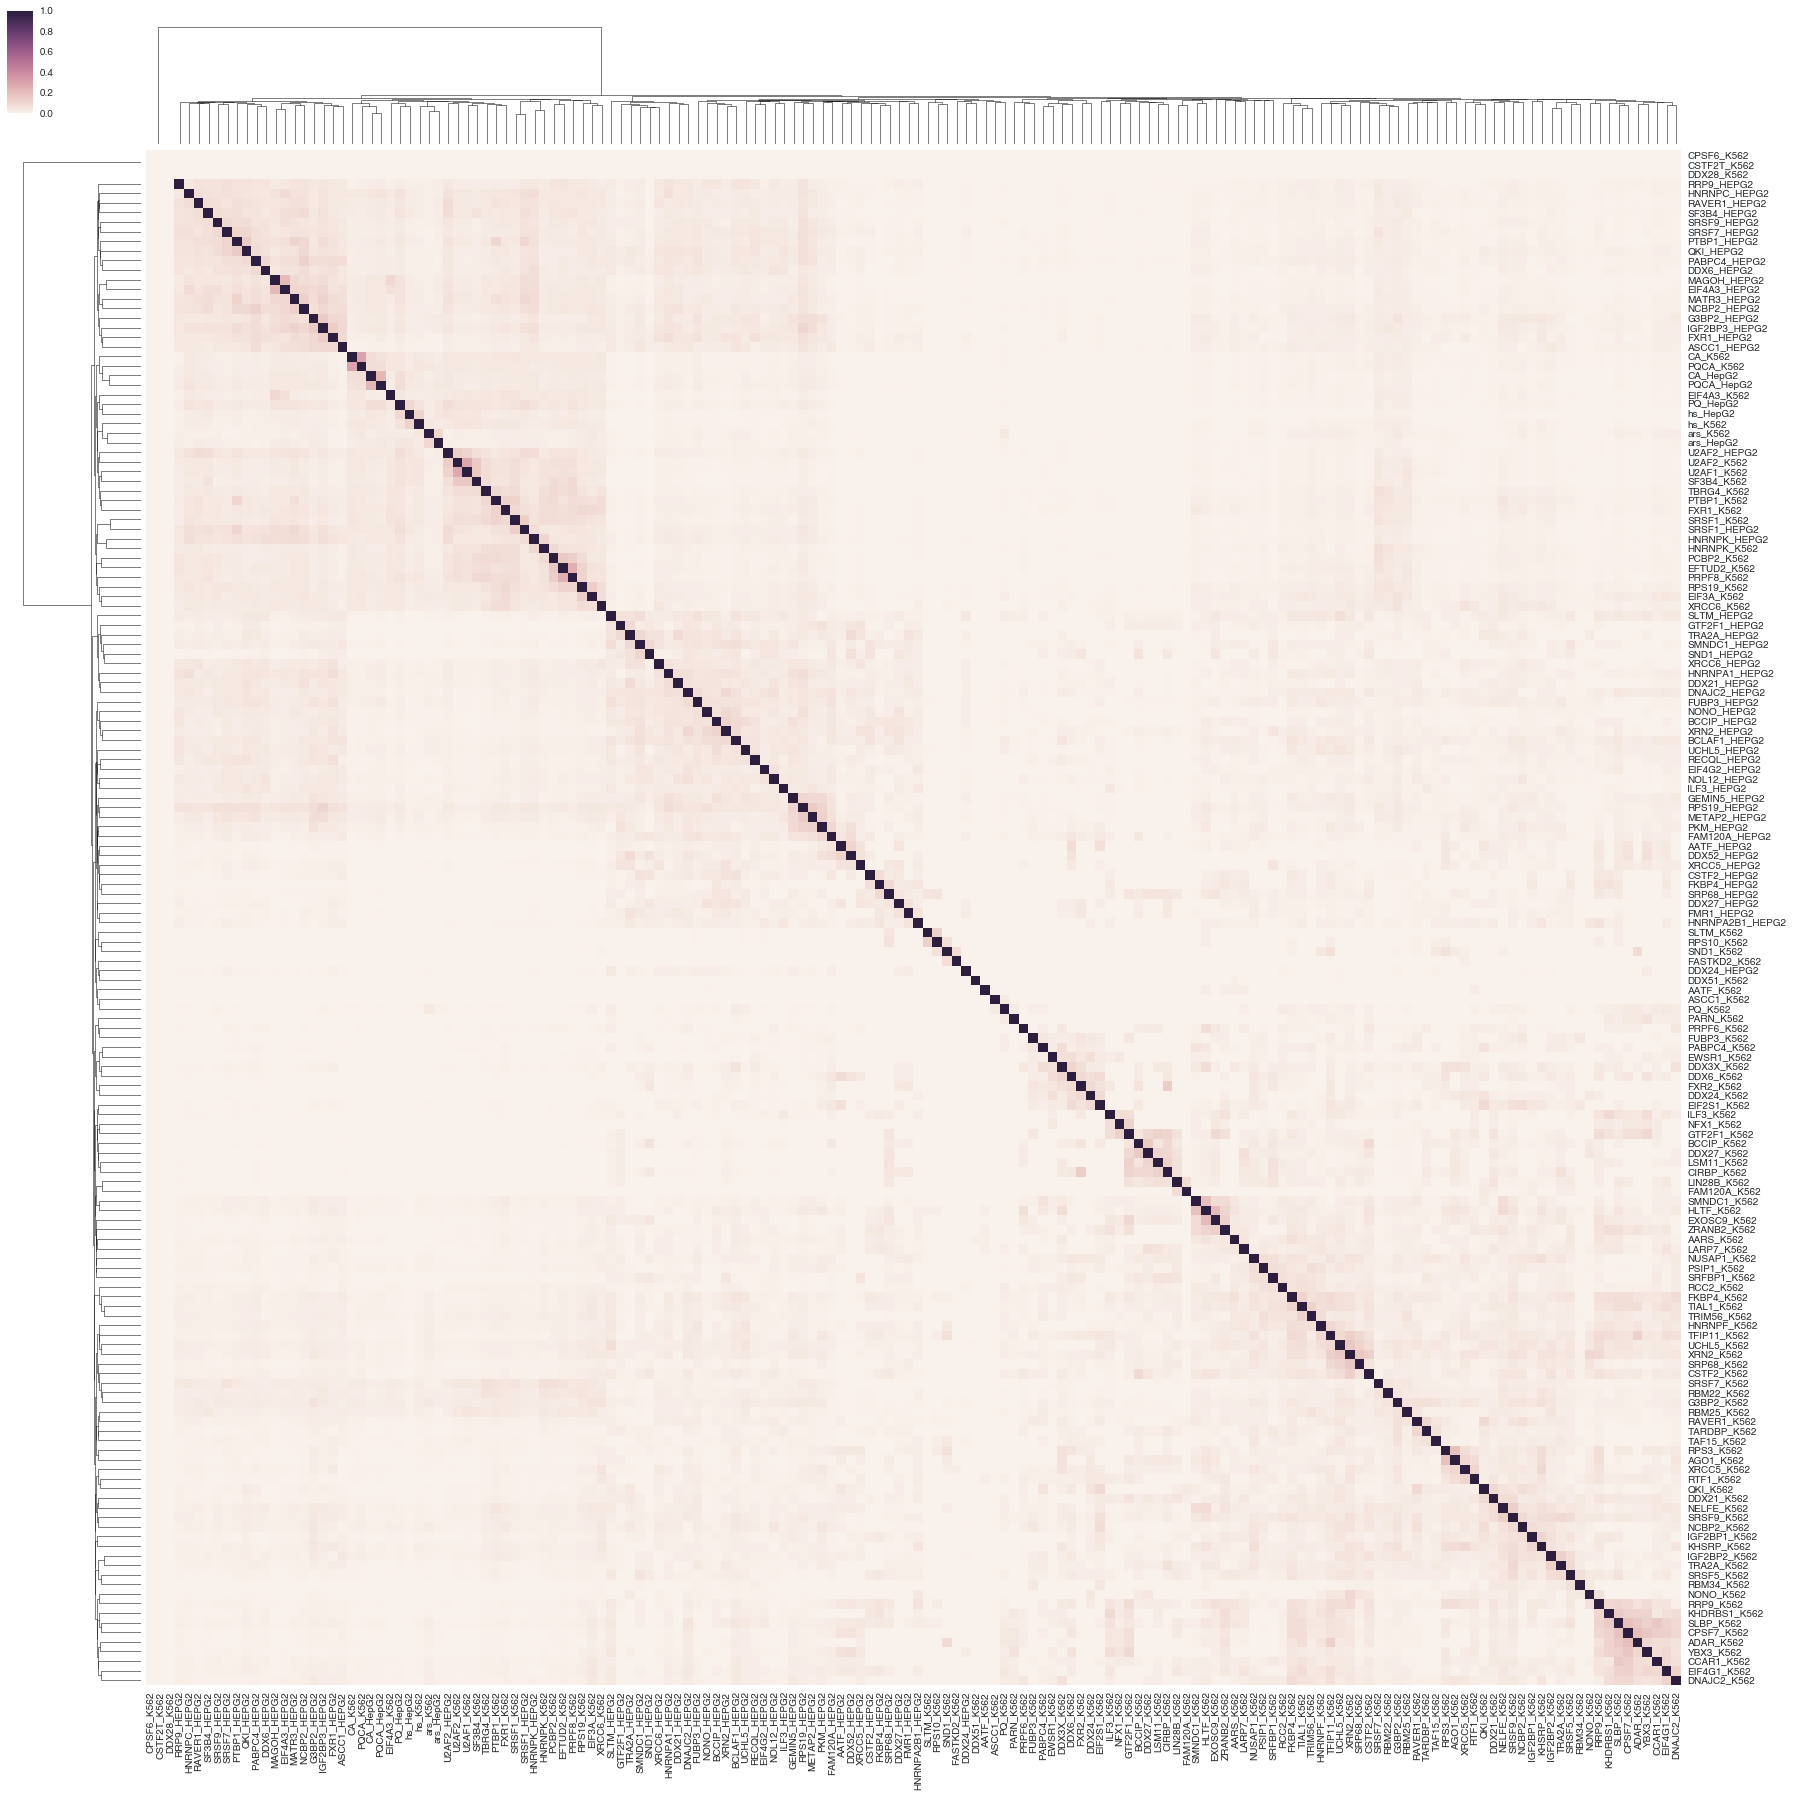

In [221]:
sns.clustermap(jaccard_matrix, figsize=(30,30))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.pdf"))  

In [222]:
stress_ids = ["CA_HepG2", "CA_K562", "PQ_HepG2", "PQ_K562", "PQCA_HepG2", "PQCA_K562", "ars_HepG2", "ars_K562", 
              "hs_HepG2", "hs_K562",]

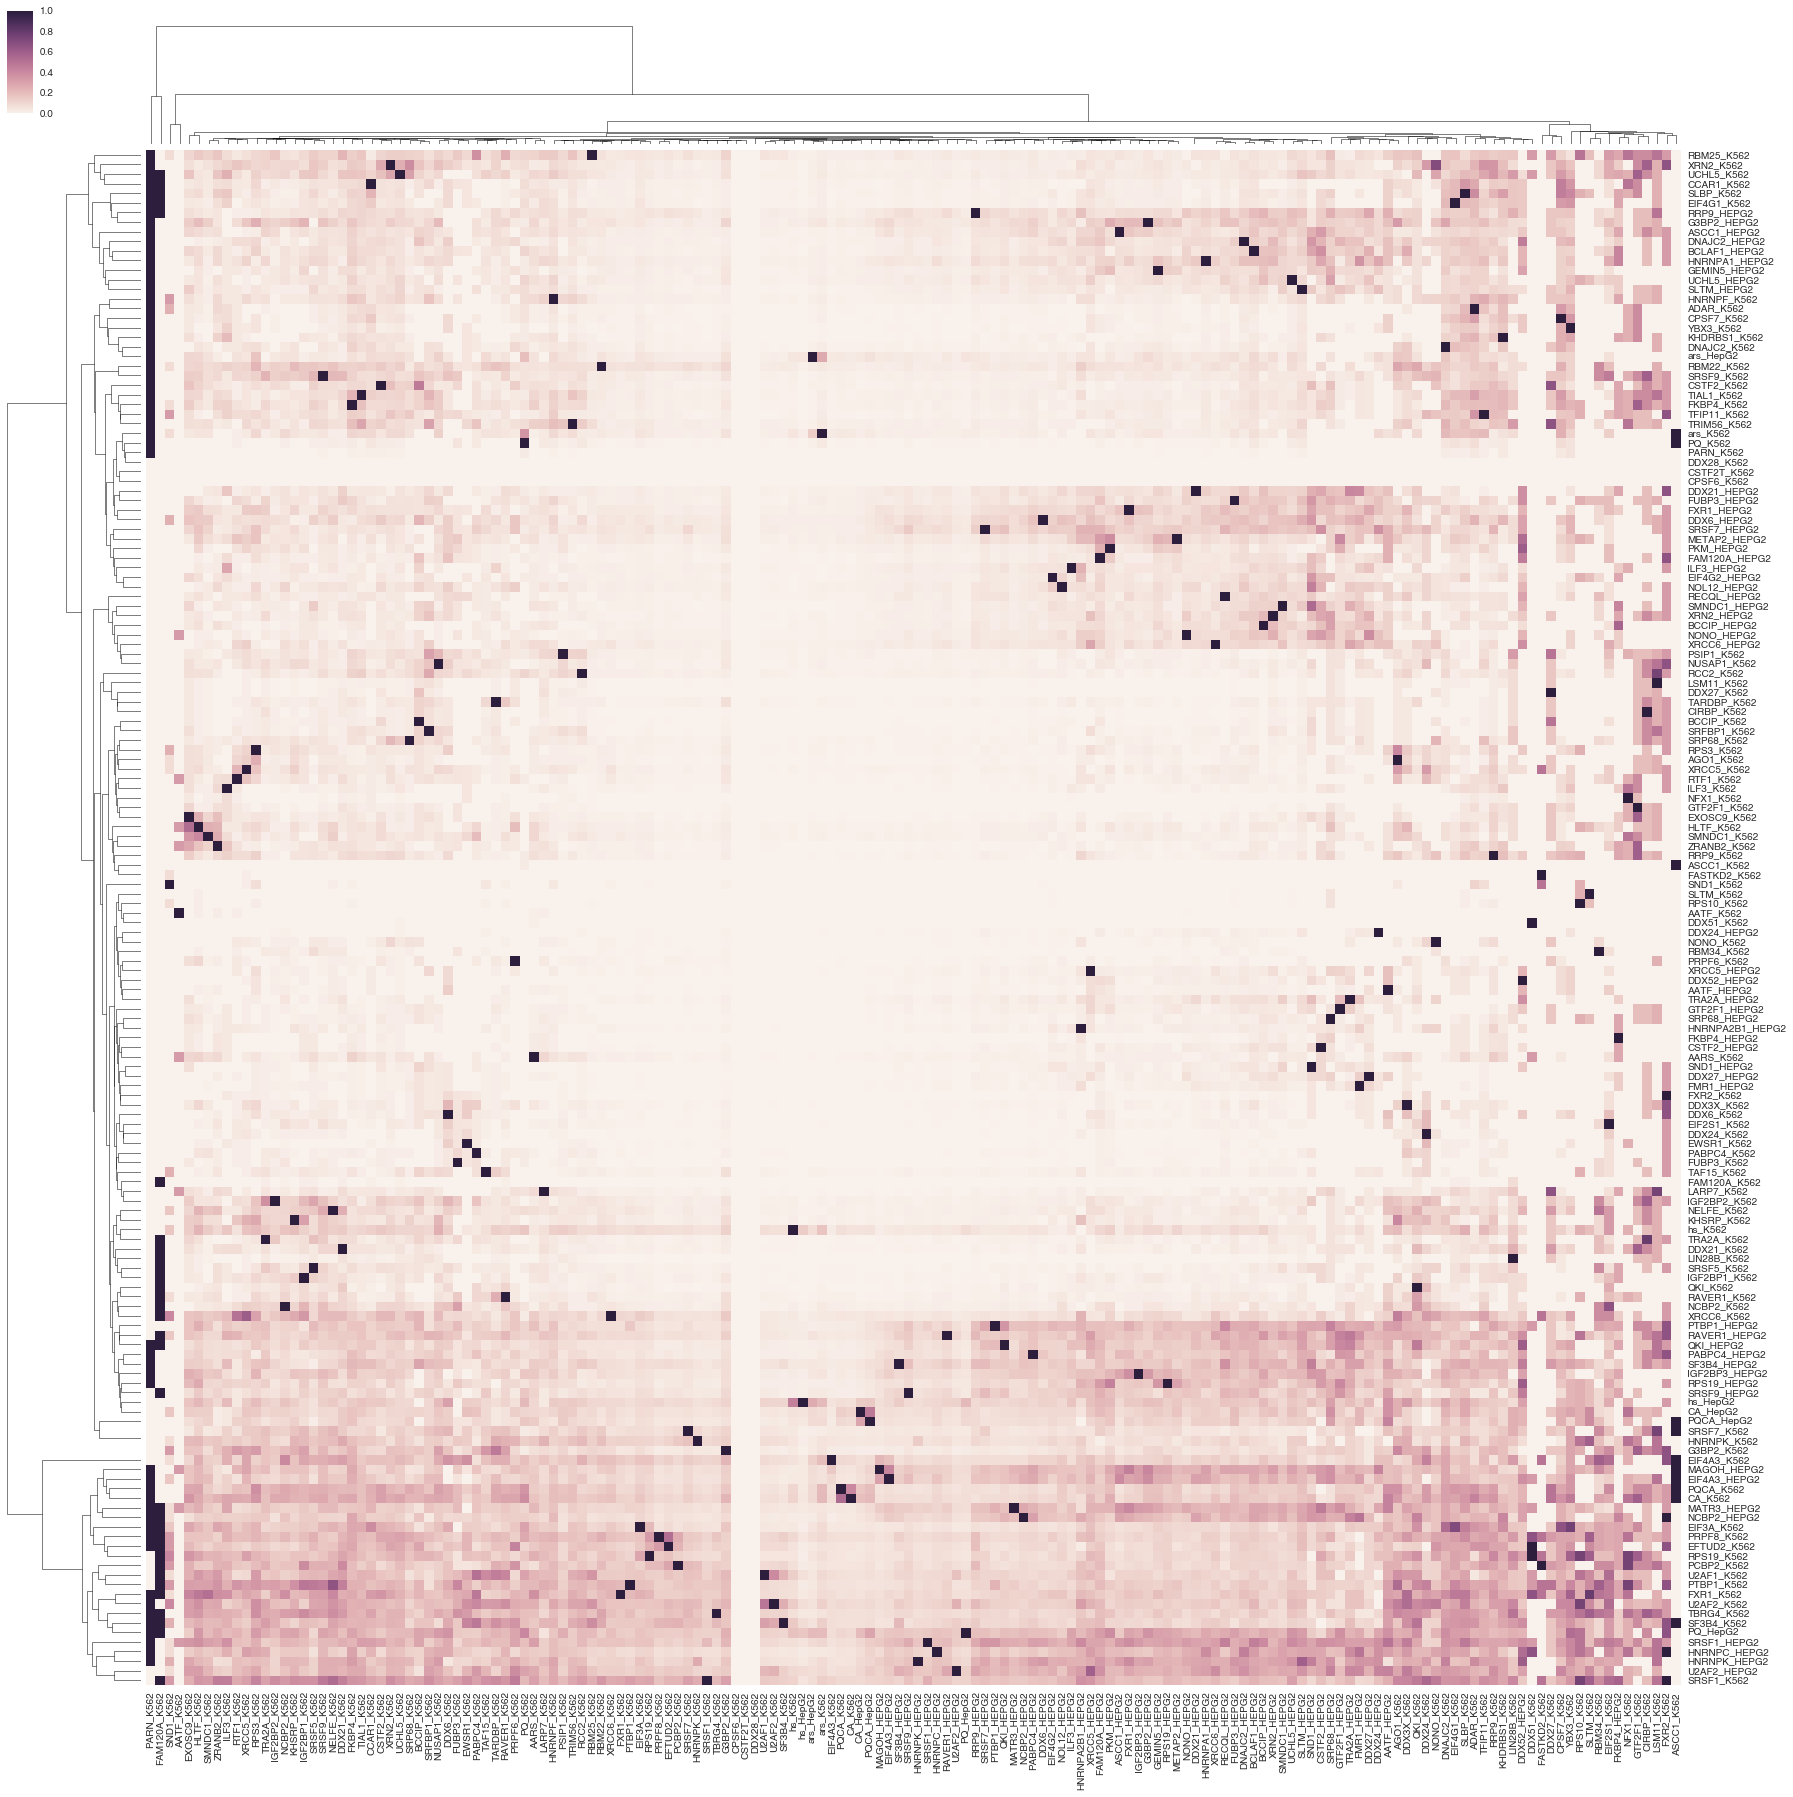

In [223]:
sns.clustermap(fraction_matrix, figsize=(30,30))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_events.pdf"))  

In [224]:
fraction_explained_by_rnai = fraction_matrix.ix[stress_ids][fraction_matrix.columns.difference(stress_ids)]

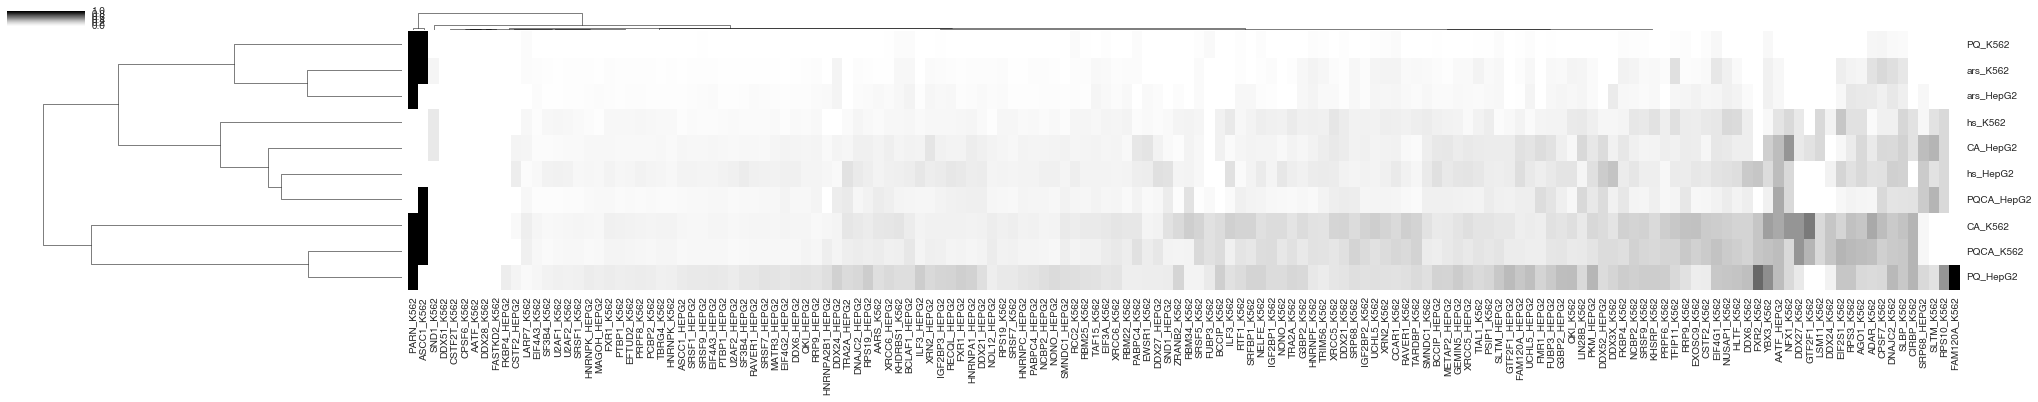

In [225]:
#Fraction of shRNA events explained by stress response
sns.clustermap(fraction_explained_by_rnai, cmap="Greys", figsize=(35,5))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_explained_events_by_rnai.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_explained_events_by_rnai.pdf"))  

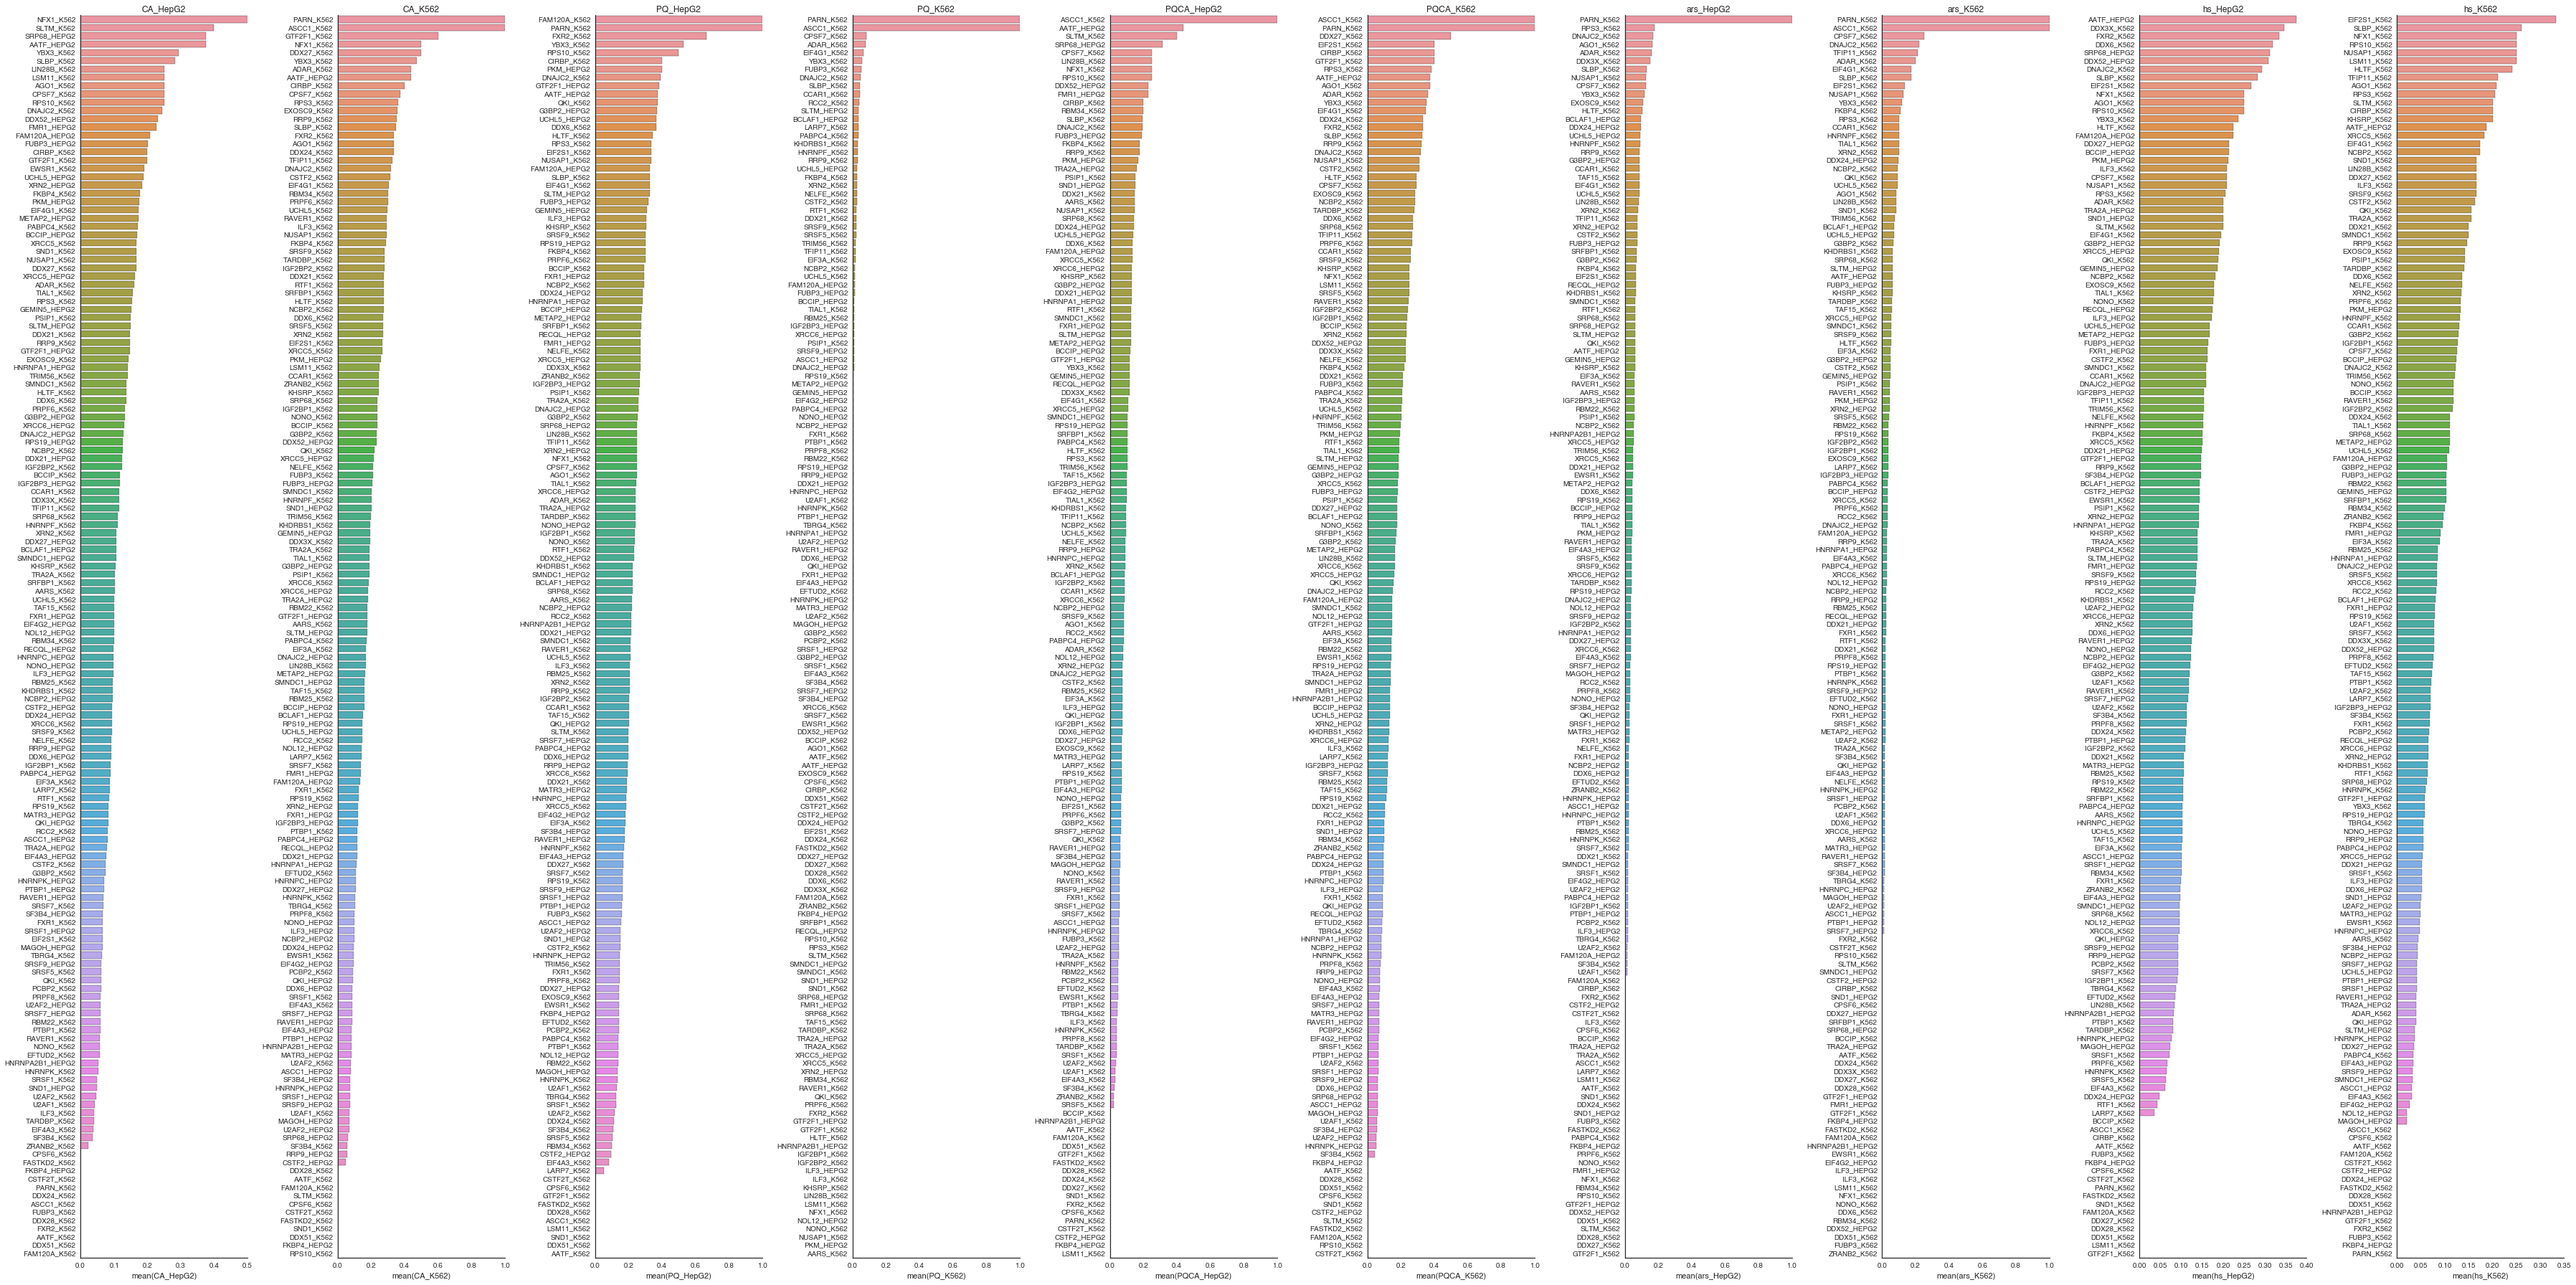

In [226]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_explained_events.svg"), figsize=( num_cols * 5, num_rows * 25)) as fig:
    
    for x, stress_event in enumerate(fraction_explained_by_rnai.index):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=fraction_explained_by_rnai.ix[stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

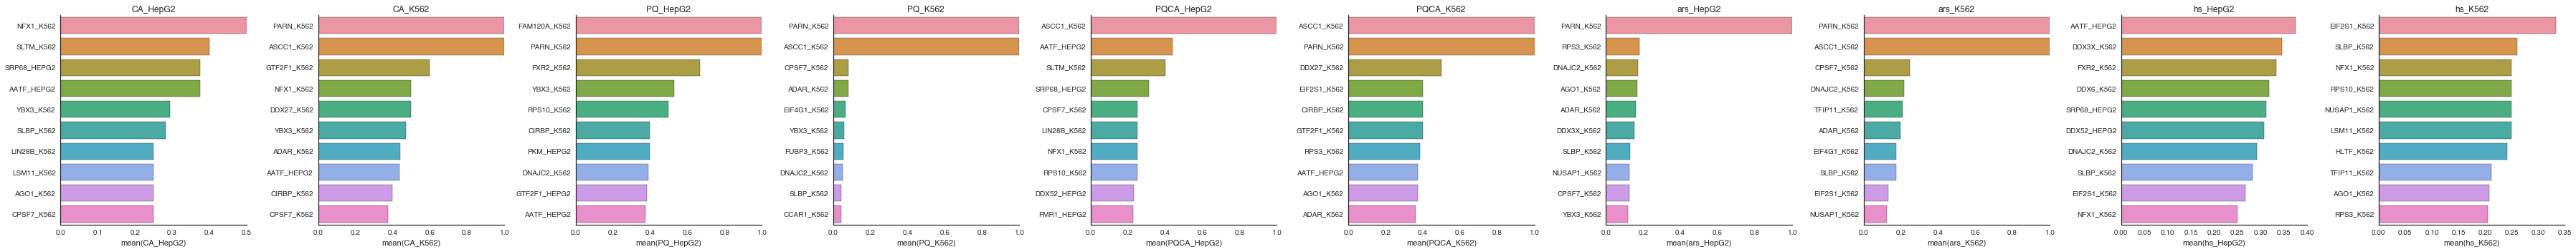

In [227]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_filtered_explained_events.svg"), figsize=( num_cols * 5, num_rows * 5)) as fig:
    
    for x, stress_event in enumerate(fraction_explained_by_rnai.index):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=fraction_explained_by_rnai.ix[stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai.ix[stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

Do this per cell type, not intra-cell types

#Lets look at bound and regulated ranked as well

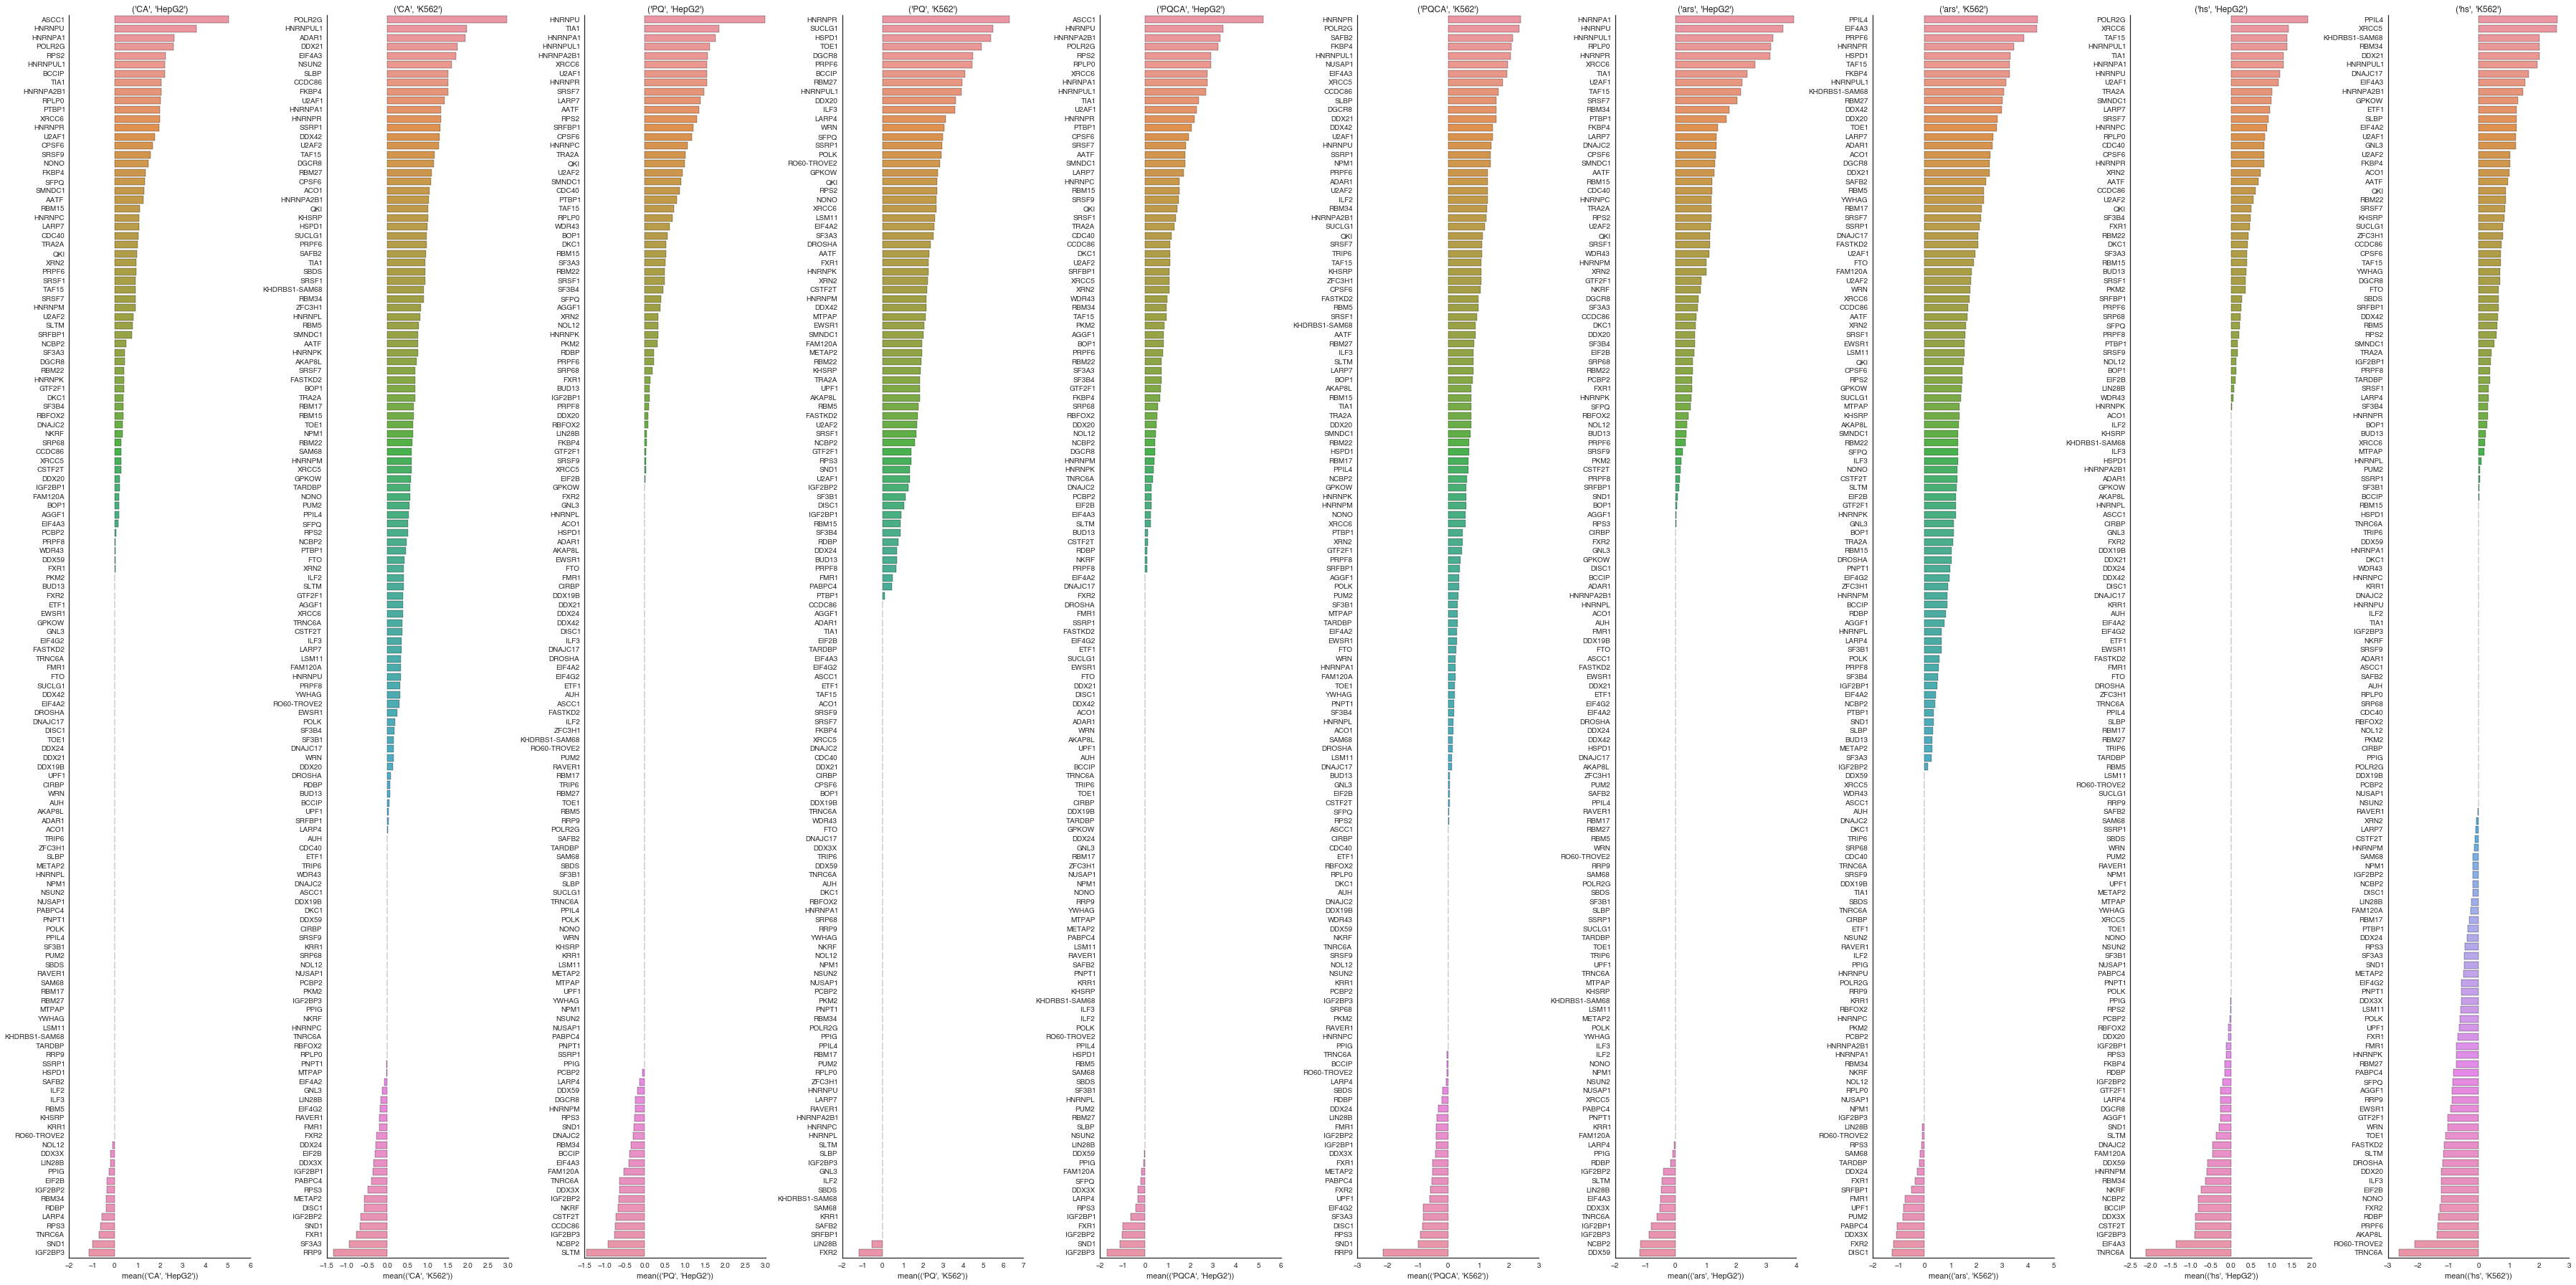

In [297]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "internal_enriched_ranking.svg"), figsize=( num_cols * 5, num_rows * 25)) as fig:
    
    for x, stress_event in enumerate(fraction_explained_by_rnai.index):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=internal_fraction_enriched.ix[stress_event].sort_values(ascending=False), 
                    y=internal_fraction_enriched.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

In [243]:
fraction_explained_by_rnai.index = pd.MultiIndex.from_tuples(fraction_explained_by_rnai.index.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])
fraction_explained_by_rnai.columns = pd.MultiIndex.from_tuples(fraction_explained_by_rnai.columns.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])

fraction_explained_by_rnai_hepg2 = fraction_explained_by_rnai.xs("HepG2", level="cell_type").xs("HEPG2", level="cell_type", axis=1)
fraction_explained_by_rnai_k562 = fraction_explained_by_rnai.xs("K562", level="cell_type").xs("K562", level="cell_type", axis=1)

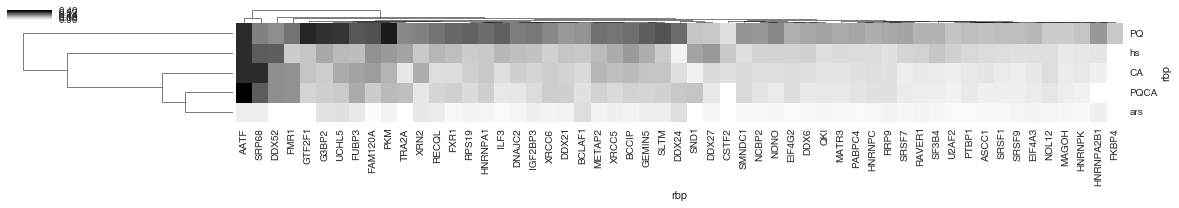

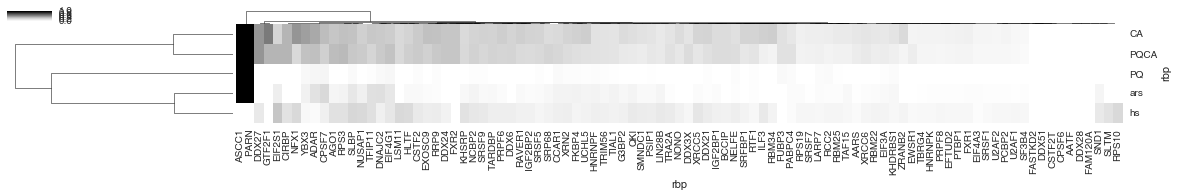

In [246]:
#Fraction of shRNA events explained by stress response
sns.clustermap(fraction_explained_by_rnai_hepg2, cmap="Greys", figsize=(20,2))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_hepg2.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_hepg2.pdf"))  

sns.clustermap(fraction_explained_by_rnai_k562, cmap="Greys", figsize=(20,2))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_k562.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_k562.pdf"))  

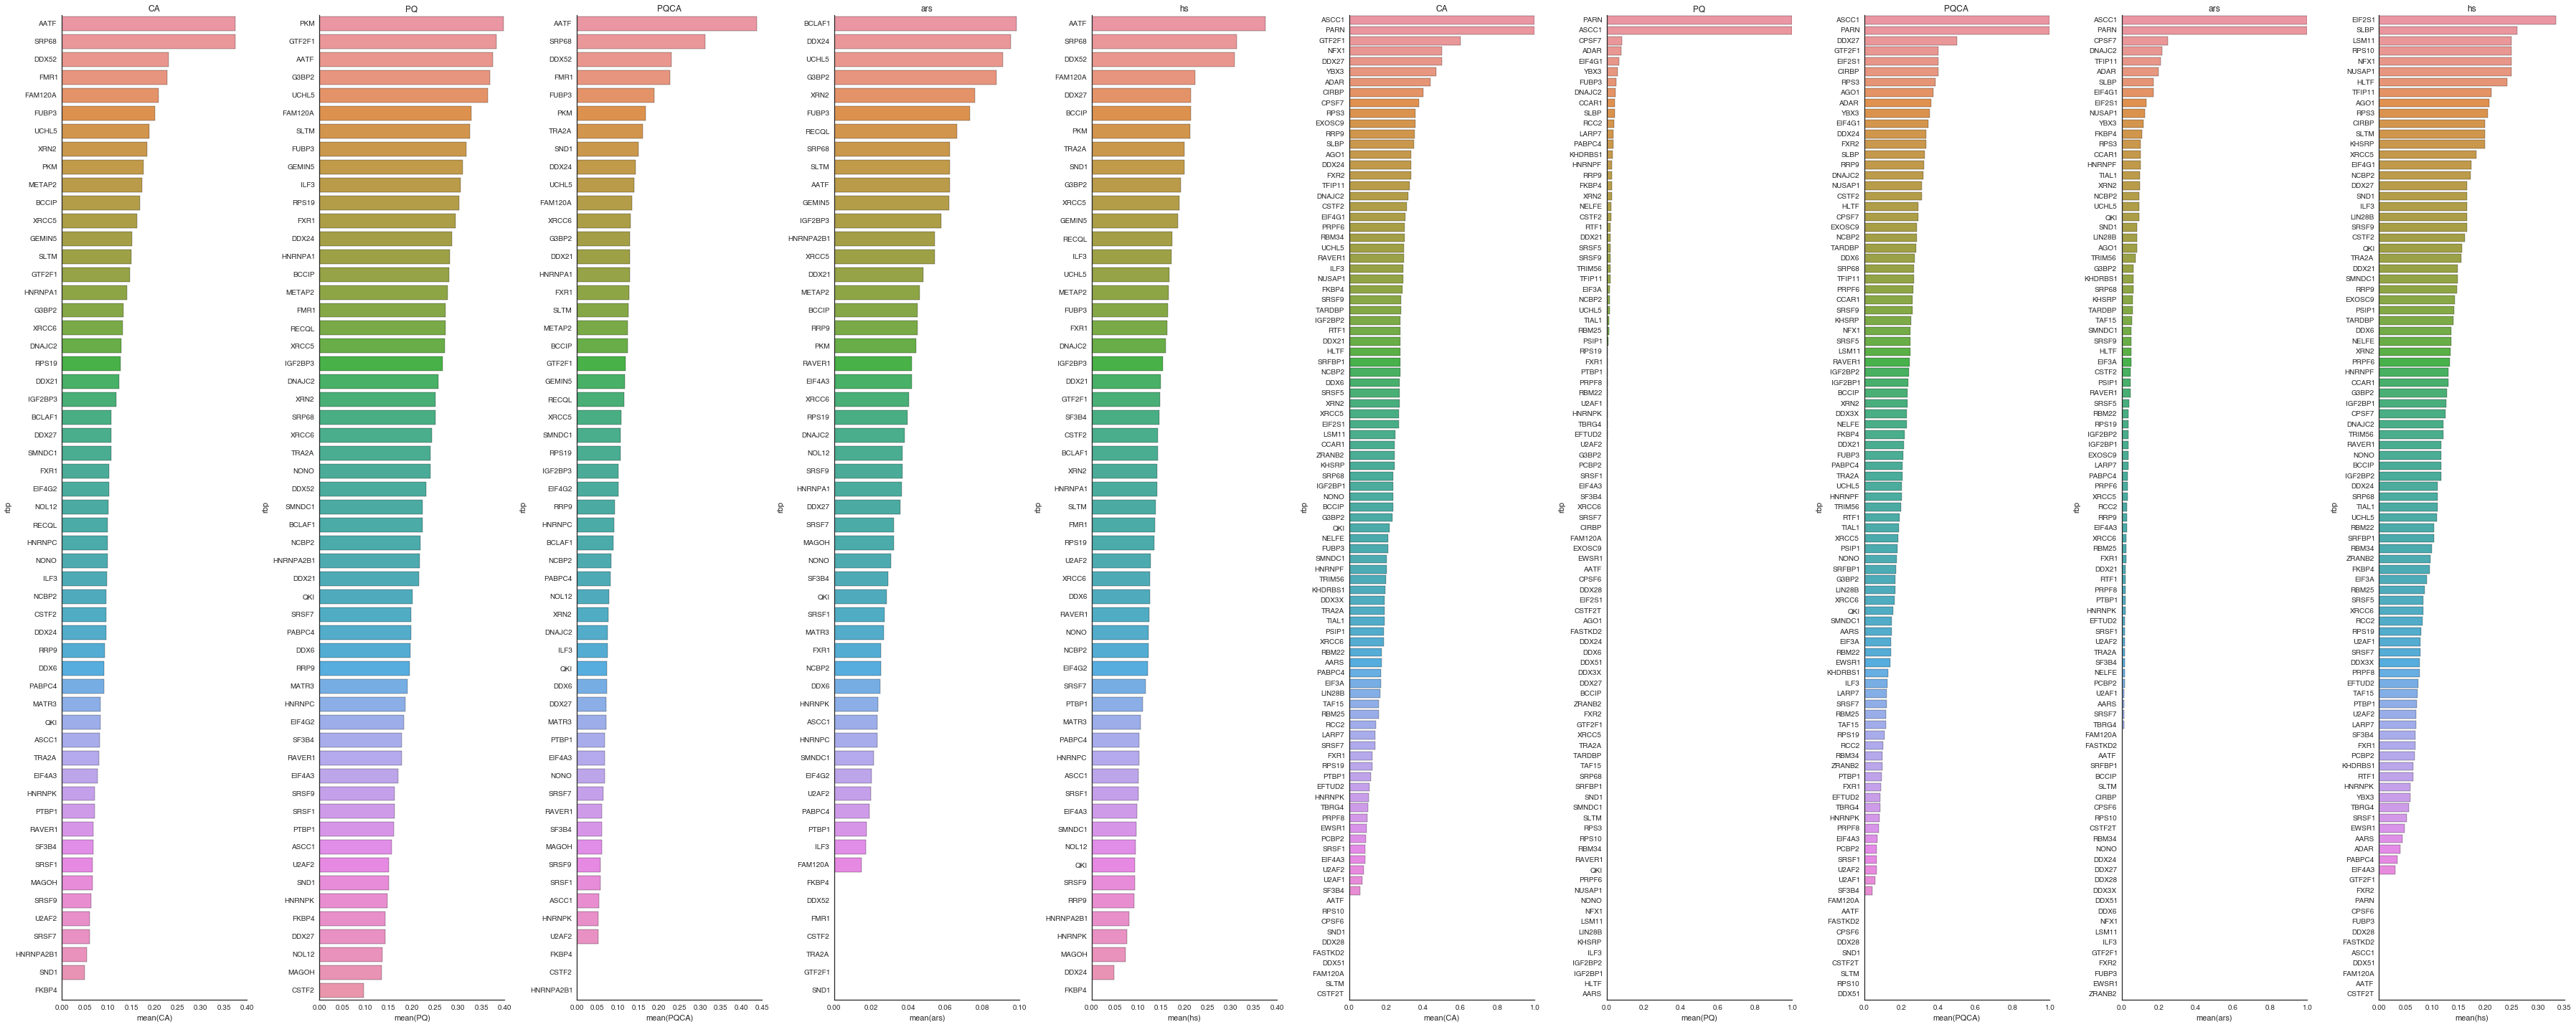

In [250]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_explained_events_cell_type_specific.svg"), figsize=( num_cols * 5, num_rows * 20)) as fig:
    count = 0
    for x, stress_event in enumerate(fraction_explained_by_rnai_hepg2.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)
    
    for x, stress_event in enumerate(fraction_explained_by_rnai_k562.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

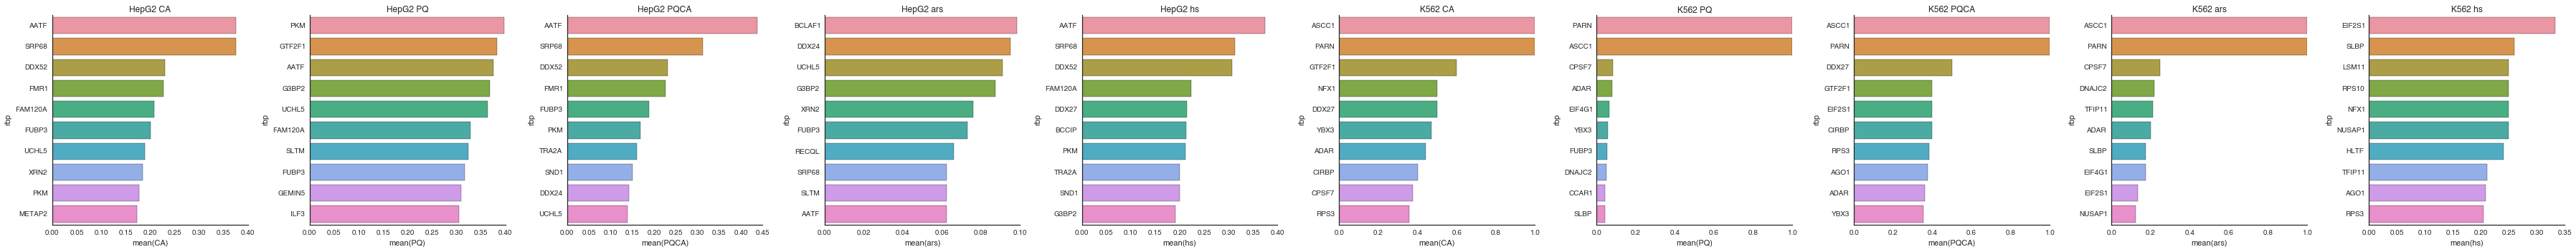

In [251]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_filtered_explained_events_cell_type_specific.svg"), figsize=( num_cols * 5, num_rows * 5)) as fig:
    count = 0
    for x, stress_event in enumerate(fraction_explained_by_rnai_hepg2.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title("HepG2 " + stress_event)
        sns.despine(ax=ax)
    
    for x, stress_event in enumerate(fraction_explained_by_rnai_k562.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title("K562 " + stress_event)
        sns.despine(ax=ax)

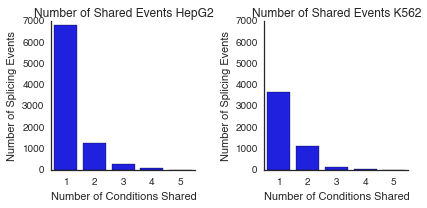

In [118]:
num_rows = 1
num_cols = 2 
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_cell_type.svg"), figsize=(num_cols * 3, num_rows * 3)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    se_events = all_sig_stress_events.xs("SE").xs("HepG2", level="cell_type").dropna(how="all", axis=1)    
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events HepG2")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")
    ax.set_ylim(0,7000)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    se_events = all_sig_stress_events.xs("SE").xs("K562", level="cell_type").dropna(how="all", axis=1)    
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events K562")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")
    ax.set_ylim(0,7000)

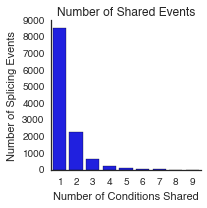

In [119]:
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events.svg"), figsize=(3, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    se_events = all_sig_stress_events.xs("SE").dropna(how="all", axis=1)
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")

Work of defining a core splicing code between cell types

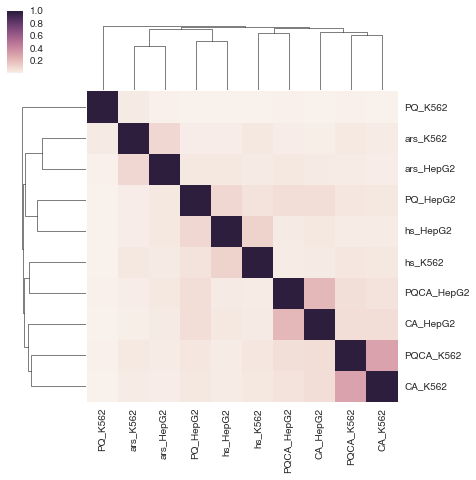

In [108]:
sns.clustermap(jaccard_matrix.ix[stress_ids][stress_ids], figsize=(7,7))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_stress_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_stress_events.pdf"))  

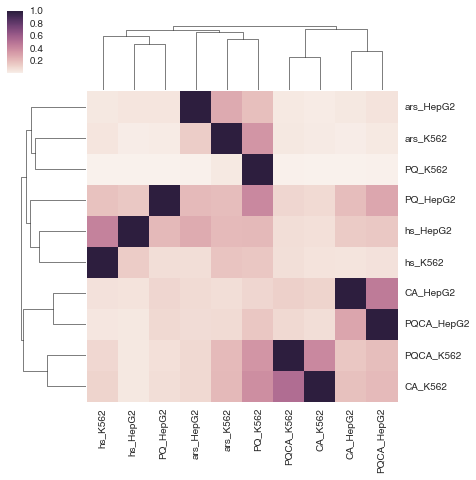

In [109]:
sns.clustermap(fraction_matrix.ix[stress_ids][stress_ids], figsize=(7,7))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.pdf"))  

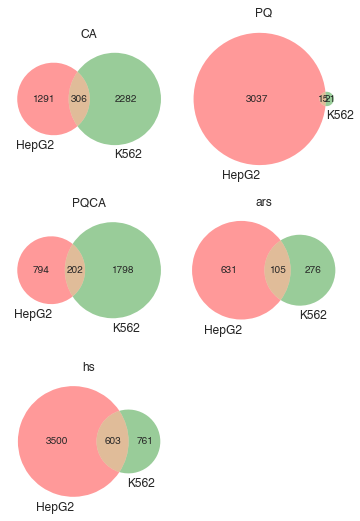

In [120]:
num_rows = 3
num_cols = 2
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_cell_type.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    
    for x, (name, df) in enumerate(se_events.groupby("rbp")):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        by_cell_type = df.groupby("cell_type")
        
        hepg2_events = by_cell_type.get_group("HepG2").group_id.values
        k562_events = by_cell_type.get_group("K562").group_id.values
        venn2([set(hepg2_events), set(k562_events)], set_labels=['HepG2', 'K562'])
        ax.set_title(name)

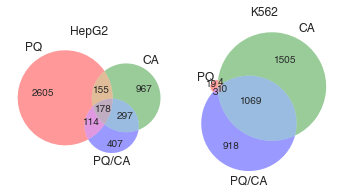

In [121]:
num_rows = 3
num_cols = 2
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_pqca.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    
    for x, (name, df) in enumerate(se_events.groupby("cell_type")):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        by_cell_type = df.groupby("rbp")
        
        pq_events = by_cell_type.get_group("PQ").group_id.values
        ca_events = by_cell_type.get_group("CA").group_id.values
        pqca_events = by_cell_type.get_group("PQCA").group_id.values

        venn3([set(pq_events), set(ca_events), set(pqca_events)], set_labels=['PQ', 'CA', 'PQ/CA'])
        ax.set_title(name)

#Go Analysis on spliced exons

In [122]:
hg19go = GO.GO(GOFile="/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [123]:
result = {}
for name, df in se_events.groupby(['rbp', 'cell_type']):
    enrichment = hg19go.enrichment(gencode_to_ensembl(df.GeneID))
    enrichment = enrichment[enrichment['Bonferroni-corrected Hypergeometric p-Value'] < .05]
    result[name] = enrichment
    
go_analysis = pd.concat(result, names=['condition', 'GO Term Accession'])

/home/gpratt/gscripts/gscripts/GO/GO.py:87: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


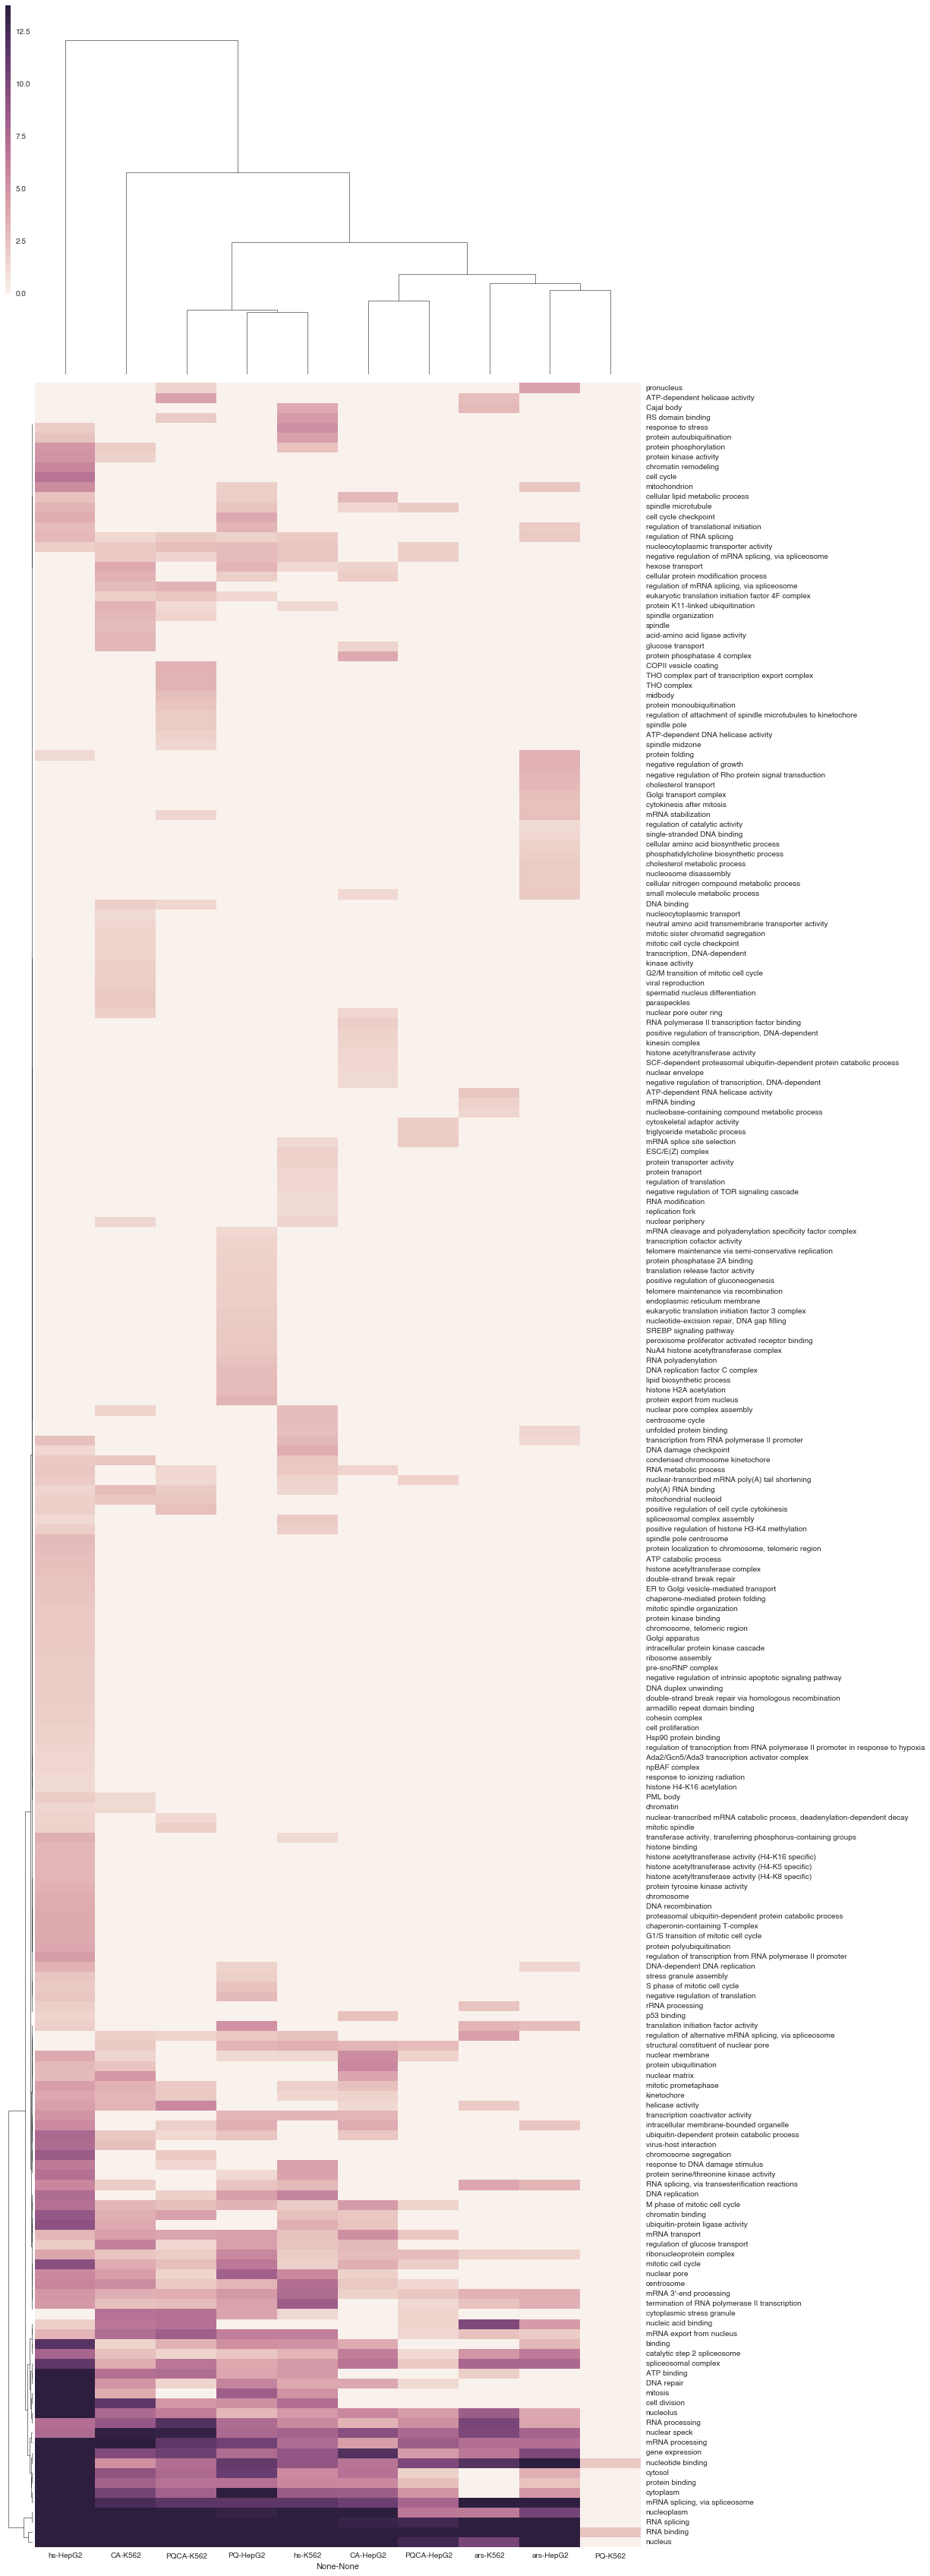

In [124]:
dataviz.plot_go_enrichment(go_analysis, figsize=(15,60))

/home/gpratt/gscripts/gscripts/general/dataviz.py:1488: FutureWarning: order is deprecated, use sort_values(...)
  go_matrix = go_matrix.ix[go_matrix.max(axis=1).order(ascending=False).index].ix[:max_terms]


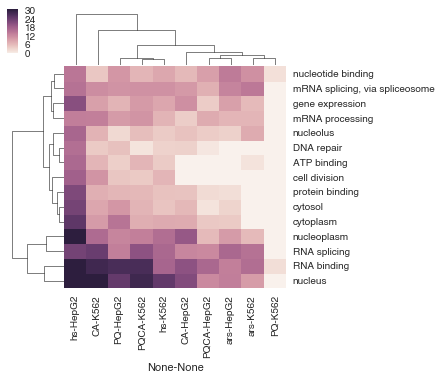

In [125]:
dataviz.plot_go_enrichment(go_analysis, figsize=(5,5), max_terms=15)
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "go_on_differentally_spliced.svg"))
fig.savefig(os.path.join(heatmap_dir, "go_on_differentally_spliced.pdf"))  

do the expression level analysis

I'll make a list of positive controls, found a few known splicing events already.  Sebastian also mentioned that he knew a few

Try to define core set of splice responsive stressors

ok, for fig 2, it'll be interesting to see if there's a core set of stress responsive alternative exons, the venn diagram here would be interesting



splicing stress response is largely unique except in the case of PQCA and CA which overlap.  It also looks like the CA treatment is driving the splicing changes not the PQ treatment

The cryptic exon finder also finds annotated exons, also the way they define exons is something I'll need to look into.  Its not consistant between experiments, which doesn't make much sense to me.  

#Lets look at known SG proteins

In [126]:
sg_rbps = pd.read_csv("/home/gpratt/Dropbox/cryptic_splicing/data/clip/KnownSGprot_long.csv")

In [128]:
internal_stress_fraction_bound = internal_fraction_enriched.ix[stress_conditions].fillna(0)

In [129]:
sg_internal_fraction = internal_stress_fraction_bound[internal_stress_fraction_bound.columns & sg_rbps['Gene Symbol']]
not_sg_internal_fraction = internal_stress_fraction_bound[internal_stress_fraction_bound.columns.difference(sg_rbps['Gene Symbol'])]

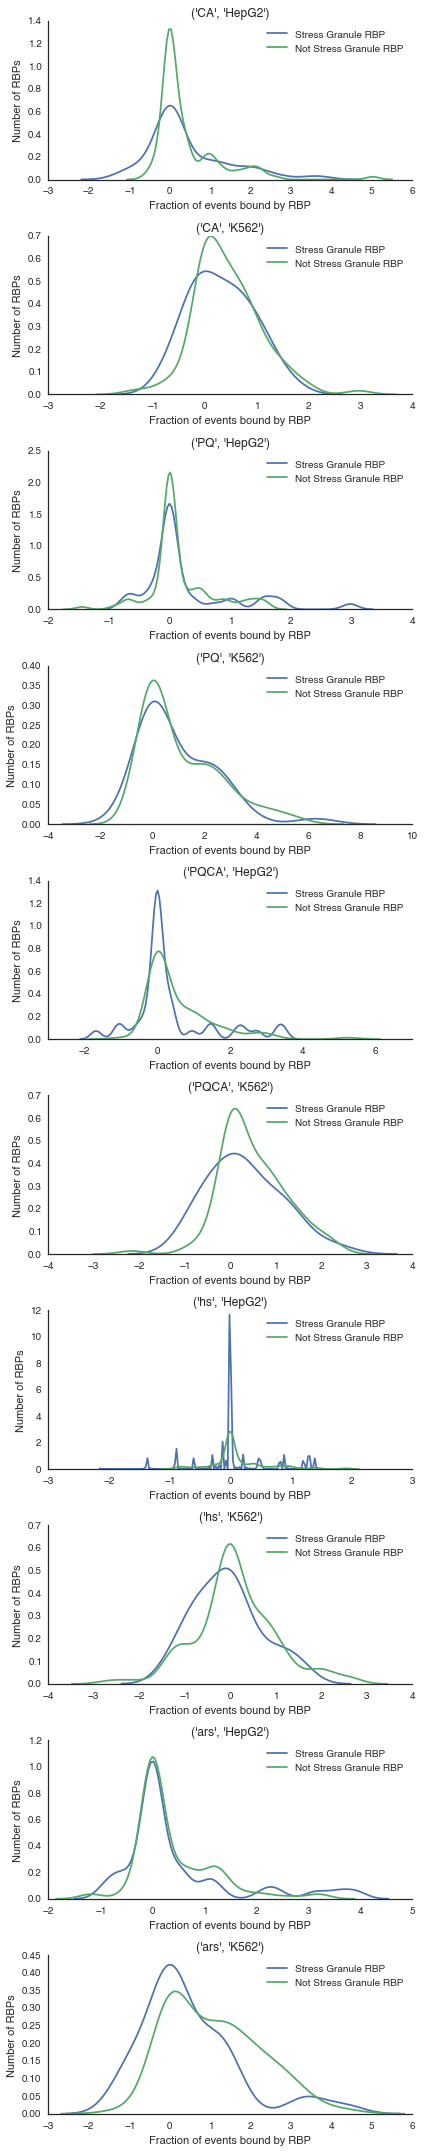

In [130]:
#fraction of events that are bound proximally by RBP
num_rows = len(sg_internal_fraction.index)
num_cols = 1
with dataviz.Figure(os.path.join(heatmap_dir, "sg_plot.svg"), figsize=(num_cols * 6, num_rows * 3)) as fig:
    for x, condition in enumerate(sg_internal_fraction.index):
        
        ax = fig.add_subplot(len(sg_internal_fraction.index),1,x + 1)

        sns.distplot(sg_internal_fraction.ix[condition], hist=False, label="Stress Granule RBP")
        sns.distplot(not_sg_internal_fraction.ix[condition], hist=False, label="Not Stress Granule RBP")
        sns.despine(ax=ax)
        ax.set_title(condition)
        ax.set_xlabel("Fraction of events bound by RBP")
        ax.set_ylabel("Number of RBPs")


In [147]:
intersting_rbps = [(u'PQ', "HepG2"), (u'hs', "HepG2"),
                  (u'PQ', "K562"), (u'hs', "K562")]

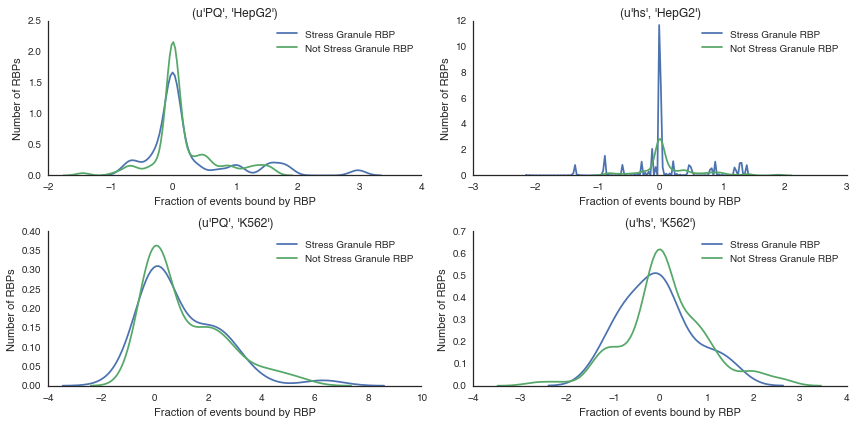

In [150]:
#fraction of events that are bound proximally by RBP
num_rows = len(intersting_rbps) / 2 
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "sg_plot_limited.svg"), figsize=(num_cols * 6, num_rows * 3)) as fig:
    for x, condition in enumerate(intersting_rbps):
        
        ax = fig.add_subplot(num_rows,2,x + 1)

        sns.distplot(sg_internal_fraction.ix[condition], hist=False, label="Stress Granule RBP")
        sns.distplot(not_sg_internal_fraction.ix[condition], hist=False, label="Not Stress Granule RBP")
        sns.despine(ax=ax)
        ax.set_title(condition)
        ax.set_xlabel("Fraction of events bound by RBP")
        ax.set_ylabel("Number of RBPs")